In [2]:
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import plotly.express as px
import re
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler

# Functions

In [3]:
def preprocess_features(data_path):
    """
    Reads JSON data from the specified path, extracts features for each entity,
    and returns a DataFrame with features as columns and a custom key as the index.
    The key is formatted as '{table_name}-{idRow}-{idColumn}' and accommodates multiple tables.

    Parameters:
        data_path (str): Path to the JSON file containing entity data.

    Returns:
        pd.DataFrame: A DataFrame with features as columns and custom key as the index.
    """
    # Read the JSON file
    with open(data_path, 'r') as f:
        data = json.load(f)

    # Initialize a list to store each row's features
    rows = []

    # Iterate over the tables (assuming 'semanticAnnotations' contains multiple tables)
    annotations = data.get('semanticAnnotations', {}).get('cea', [])
    if isinstance(annotations, list):  # Support single list structure as well
        annotations = [annotations]

    for table_annotations in annotations:
        table_name = data.get("tableName", "unknown_table")

        for annotation in table_annotations:
            # Ensure there is an entity present
            if annotation['entity']:
                first_entity = annotation['entity'][0]
                id_row = annotation.get('idRow')
                id_column = annotation.get('idColumn')

                # Generate the key in the format "{table_name}-{idRow}-{idColumn}"
                key = f"{table_name}-{id_row}-{id_column}"

                # Extract features as a dictionary
                features = {feature['id']: feature['value'] for feature in first_entity.get('features', [])}
                features['key'] = key  # Include the custom key in the DataFrame

                # Append the features dictionary to rows
                rows.append(features)

    # Create DataFrame and set 'key' as index
    df = pd.DataFrame(rows).set_index('key')

    return df

def extract_distribution_statistics(features_df):
    """
    Extracts statistical parameters for each feature in the DataFrame for distribution analysis.

    Parameters:
        features_df (pd.DataFrame): A DataFrame containing feature columns.

    Returns:
        pd.DataFrame: A DataFrame with ordered statistical parameters (mean, std_dev, min, 25%, median, 75%, max) for each feature.
    """
    # Initialize a dictionary to store statistics
    statistics = {}

    # Loop through each feature column to calculate statistics
    for column in features_df.columns:
        # Skip non-numeric columns
        if not pd.api.types.is_numeric_dtype(features_df[column]):
            continue

        # Calculate statistical parameters
        stats = {
            'mean': features_df[column].mean(),
            'std_dev': features_df[column].std(),
            'min': features_df[column].min(),
            '25%': features_df[column].quantile(0.25),
            'median': features_df[column].median(),
            '75%': features_df[column].quantile(0.75),
            'max': features_df[column].max(),
        }

        # Add stats to the dictionary
        statistics[column] = stats

    # Convert the statistics dictionary to a DataFrame
    stats_df = pd.DataFrame(statistics).T  # Transpose to make features as rows

    # Reorder columns
    stats_df = stats_df[['mean', 'std_dev', 'min', '25%', 'median', '75%', 'max']]

    return stats_df

def extract_correct_features(file_path):
    """
    Extracts features of the correct candidate entity for each row based on `rows.ids` and `semanticAnnotations.cea`.

    Parameters:
        file_path (str): Path to the JSON file.

    Returns:
        pd.DataFrame: A DataFrame with extracted features for the correct entity in each row.
    """

    # Load JSON data
    with open(file_path, 'r') as f:
        data = json.load(f)

    extracted_data = []  # To store extracted features

    # Iterate over each row to find the correct ID
    for row in data['rows']:
        row_id = row['idRow']

        # Find the first valid ID in 'ids', ignoring empty or "NIL" entries
        correct_id = next((entity_id for entity_id in row['ids'] if entity_id != "NIL"), None)

        # Skip to the next row if there is no valid correct ID
        if correct_id is None:
            continue

        # Search in `cea` for matching idRow with idColumn = 2
        correct_entity = None
        for annotation in data['semanticAnnotations']['cea']:
            if annotation['idRow'] == row_id and annotation['idColumn'] == 2:
                # Look for the entity with the correct ID
                for entity in annotation['entity']:
                    if entity['id'] == correct_id:
                        correct_entity = entity
                        break
            if correct_entity:
                break

        # If the correct entity is found, extract features
        if correct_entity:
            features = {feature['id']: feature['value'] for feature in correct_entity.get('features', [])}
            features['idRow'] = row_id
            features['correct_id'] = correct_id
            extracted_data.append(features)

    # Convert to DataFrame
    extracted_df = pd.DataFrame(extracted_data)
    return extracted_df

def calculate_feature_correlations(features_df, method='pearson', plot=True):
    """
    Calculates the correlation matrix for the features in the DataFrame and optionally
    displays a high-resolution heatmap with a consistent color scale from -1 to +1.

    Parameters:
        features_df (pd.DataFrame): A DataFrame containing feature columns.
        method (str): Correlation method ('pearson', 'spearman', 'kendall').
        plot (bool): Whether to display a heatmap of the correlation matrix.

    Returns:
        pd.DataFrame: A DataFrame representing the correlation matrix of the features.
    """
    # Select only numeric columns for correlation calculation
    numeric_features = features_df.select_dtypes(include=['number'])

    # Calculate the correlation matrix
    correlation_matrix = numeric_features.corr(method=method)

    # Plot the heatmap if plot is True
    if plot:
        plt.figure(figsize=(24, 20), dpi=150)  # Large figure size with high DPI
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True,
                    cbar_kws={'shrink': 0.8}, fmt=".2f", linewidths=0.5,
                    vmin=-1, vmax=1)  # Set color scale to -1 to +1 for accuracy
        plt.title(f'{method.capitalize()} Correlation Matrix', fontsize=18)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()

    return correlation_matrix

def plot_feature_distributions(features_df):
    """
    Creates a large figure with histogram charts for each feature in a grid layout,
    and violin plots: one for features with values <= 1, and individual plots for features with values > 1.

    Parameters:
        features_df (pd.DataFrame): A DataFrame containing feature columns.
    """
    # Select only numeric columns for plotting
    numeric_features = features_df.select_dtypes(include=['number'])

    # Calculate grid size based on the number of features
    num_features = numeric_features.shape[1]
    grid_size = math.ceil(math.sqrt(num_features))  # Square layout

    # Set up the figure size and layout for histograms
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20), dpi=150)
    axes = axes.flatten()  # Flatten to iterate easily

    # Plot histograms for each feature
    for i, column in enumerate(numeric_features.columns):
        sns.histplot(numeric_features[column], kde=True, ax=axes[i])
        axes[i].set_title(column)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout for the histograms
    plt.tight_layout()
    plt.show()

    # Separate features based on value ranges
    features_leq_one = numeric_features.loc[:, numeric_features.max() <= 1]
    features_gt_one = numeric_features.loc[:, numeric_features.max() > 1]

    # Plot the violin plot for features with values <= 1
    if not features_leq_one.empty:
        plt.figure(figsize=(20, 10), dpi=150)
        sns.violinplot(data=features_leq_one, inner='quartile', palette='coolwarm')
        plt.xticks(rotation=45, ha='right')
        plt.title('Distribution of Features with Values <= 1')
        plt.show()

    # Plot individual violin plots for features with values > 1
    for column in features_gt_one.columns:
        plt.figure(figsize=(8, 8), dpi=150)
        sns.violinplot(y=features_gt_one[column], inner='quartile', palette='coolwarm')
        plt.title(f'Distribution of Feature: {column} (Values > 1)')
        plt.show()

def normalize_features(features_df, feature_range=(0, 1)):
    """
    Normalizes all numeric features in the DataFrame to a specified range using Min-Max scaling.

    Parameters:
        features_df (pd.DataFrame): A DataFrame containing feature columns.
        feature_range (tuple): Desired range for the scaled data (default is (0, 1)).

    Returns:
        pd.DataFrame: A DataFrame with normalized features.
    """
    # Select only numeric columns
    numeric_features = features_df.select_dtypes(include=['number'])

    # Initialize the MinMaxScaler with the desired range
    scaler = MinMaxScaler(feature_range=feature_range)

    # Fit and transform the numeric features
    normalized_data = scaler.fit_transform(numeric_features)

    # Create a DataFrame from the normalized data, retaining original feature names
    normalized_df = pd.DataFrame(normalized_data, columns=numeric_features.columns, index=features_df.index)

    # Return DataFrame with normalized features
    return normalized_df

def plot_feature_pairwise_scatter(features_df):
    """
    Creates a large scatter plot matrix for each pair of features in the DataFrame.

    Parameters:
        features_df (pd.DataFrame): A DataFrame containing feature columns.
    """
    # Select only numeric columns for plotting
    numeric_features = features_df.select_dtypes(include=['number'])

    # Set up the pairplot with a larger figure size
    sns.pairplot(numeric_features, height=2, plot_kws={'s': 10})  # 's' controls marker size

    # Show the plot
    plt.suptitle("Pairwise Scatter Plot of Features", y=1.02)  # Adjust title position
    plt.show()

# Load

In [4]:
# alligatior_annotations_path = "exampleResponse.json"
alligator_annotations_github_testset = "../Results/alligator_annotations_github-testset_babakAlessandro_02_Github_Testset.json"
# alligator_annotations_github_testset = "../Results/alligator_annotations_github-testset_allFeatures.json"

# features_df = preprocess_features(alligatior_annotations_02_path)
github_testset_features = preprocess_features(alligator_annotations_github_testset)
# github_testset_features = github_testset_features[~github_testset_features.index.str.endswith(('0', '1'))]
# github_complete_dataset_features = pd.read_csv("github_features.csv", index_col="key")

In [5]:
with open(alligator_annotations_github_testset, 'r') as f:
    data = json.load(f)

# Annotated Github Testset Analysis

The First Analysis looks into each feature, and how they are for the correct candidates.

In [6]:
## Find correct Qid for each row
correct_Qid = {row["idRow"]:row.get("ids", 'NIL') for row in data["rows"]}
rows = []

## For each annotation find the correct candidate and ewaxtract the features
for annotation in data["semanticAnnotations"]["cea"]:
    for index, entity in enumerate(annotation["entity"]):
        if entity["id"] in correct_Qid[annotation["idRow"]]:
            id_row = annotation.get('idRow')
            id_column = annotation.get('idColumn')

            # Generate the key in the format "{idRow}-{idColumn}"
            key = f"{id_row}-{id_column}"

            # Extract features as a dictionary
            features = {feature['id']: feature['value'] for feature in entity.get('features', [])}
            features['key'] = key  # Include the custom key in the DataFrame

            # Append the features dictionary to rows
            rows.append(features)
            break

# Create DataFrame and set 'key' as index
correct_candidate_features = pd.DataFrame(rows).set_index('key')
len(correct_candidate_features)


448

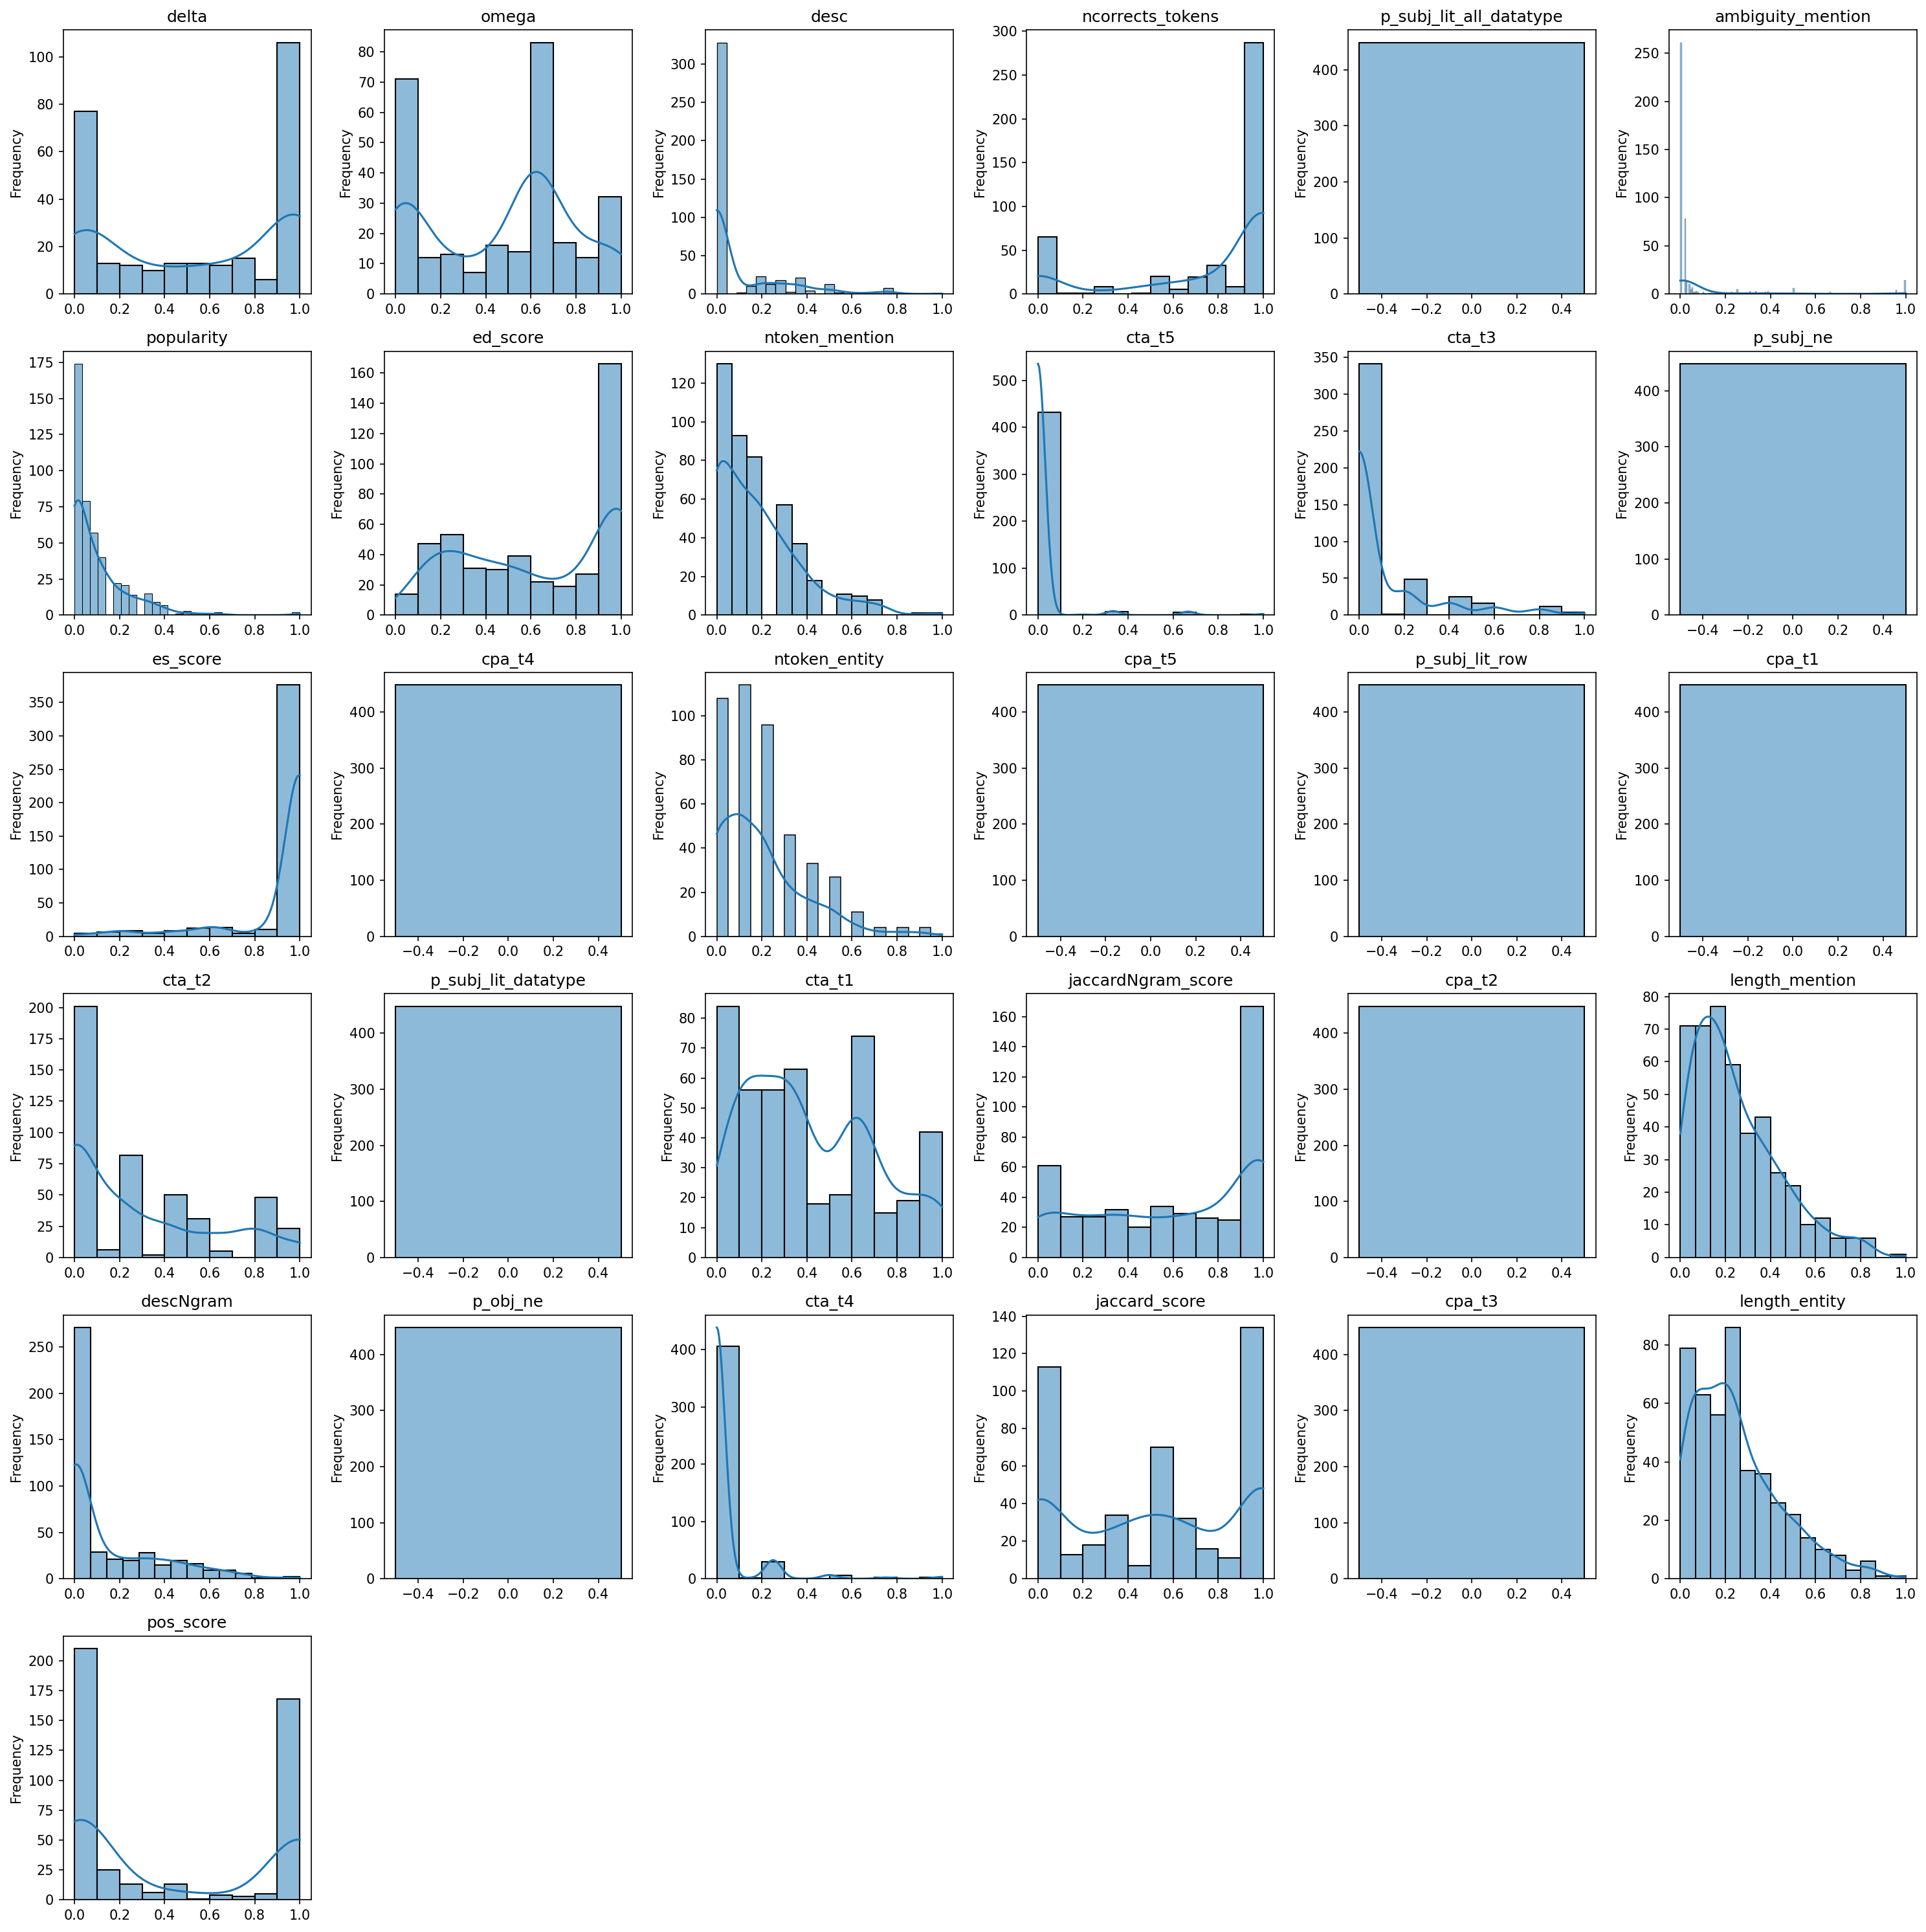

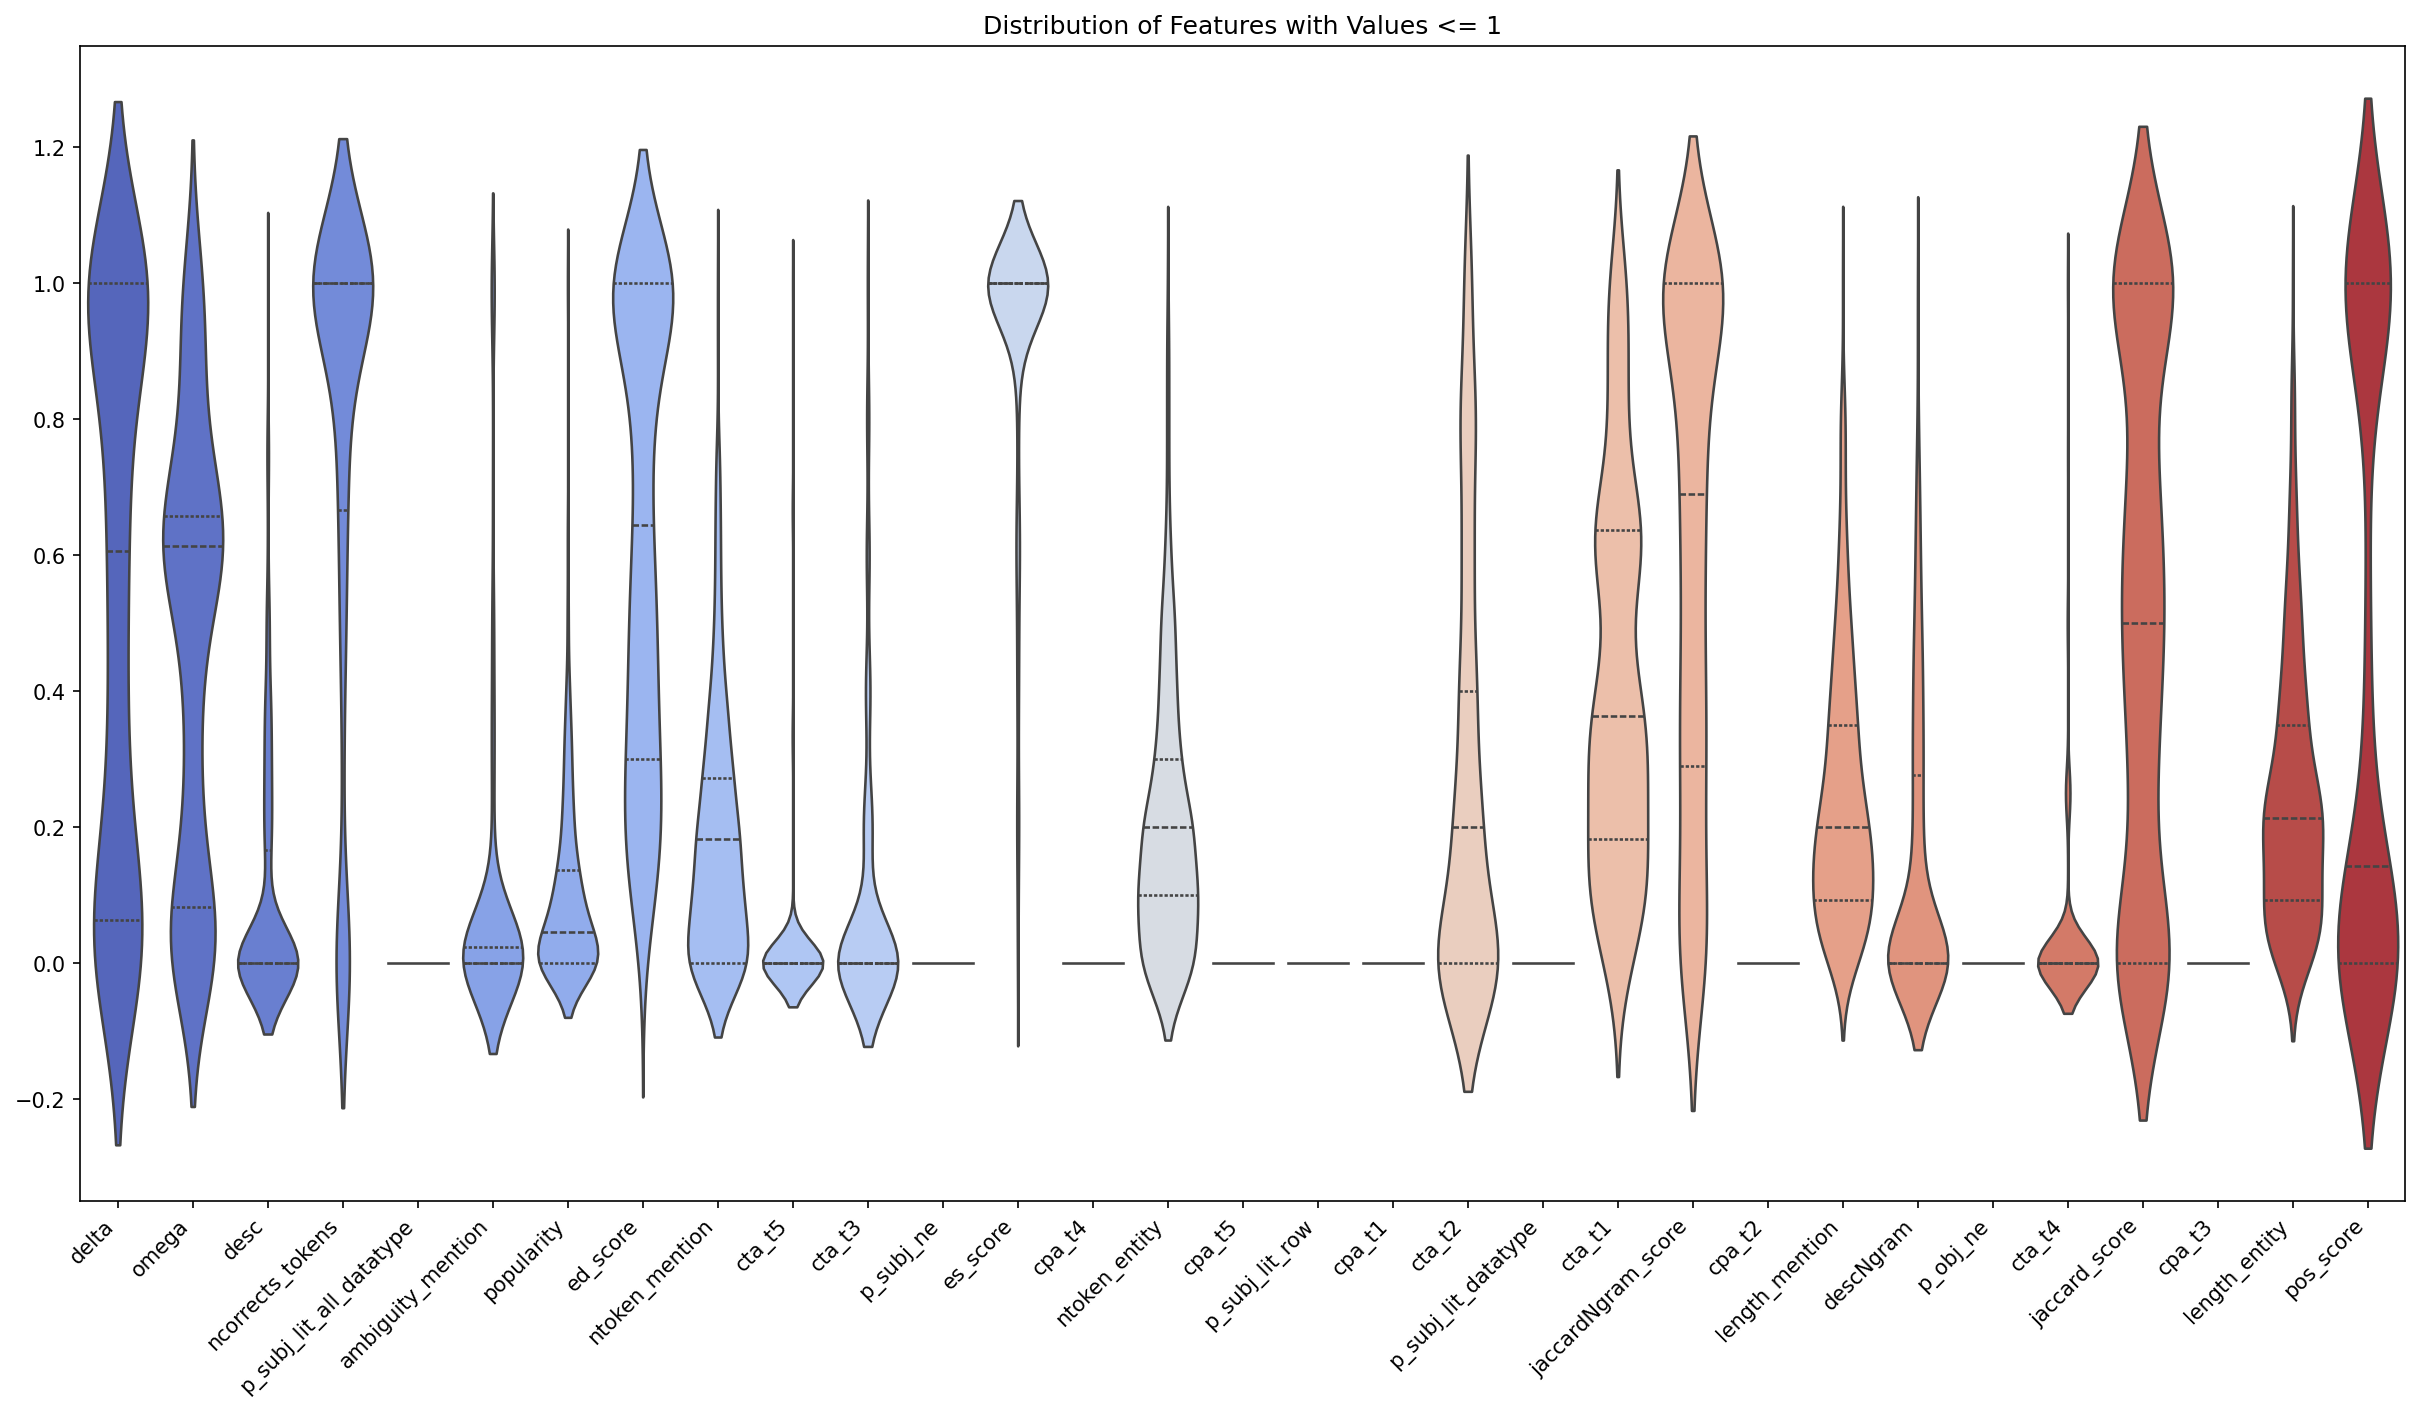

In [7]:
a = normalize_features(correct_candidate_features)
plot_feature_distributions(a)

### Question: Which features are most important in finding the correct candidate?

### A.1 relation of each score to a candidate being the correct one
Let's have a look at how each feature is correlated to a candidate's correctness.

Suspicions:
- More than one correct candidate in the list => Probably since Lamapi adds it there without checking its existence
- Are candidates closely ranked? => yes they are
- Why are all duplicated correct candidates ranked 1 and 0? Are all 0 ranked correct candidates duplicated? => All mentions that are correctly predicted (Their rank is 1) have duplicated values in the candidates.
- How many do not have any correct candidate? => 289 rows don't have correct. All are NIL values, the rest did not have any candidate there for are not in the df.
- There are 3 rows that do ot have any correct candidate and are not NIL. I assumed Lamapi adds the correct candidate in the list. ??

In [105]:
## Find correct Qid for each row
correct_Qid = {row["idRow"]:row.get("ids", 'NIL') for row in data["rows"]}
rows = []

## For each annotation extract features and append binary value if the entity is correct
for annotation in data["semanticAnnotations"]["cea"]:
    for index, entity in enumerate(annotation["entity"]):
        is_correct = False
        # Check if the entity is correct
        if entity["id"] in correct_Qid[annotation["idRow"]]:
            is_correct = True

        id_row = annotation.get('idRow')
        id_column = annotation.get('idColumn')

        # Generate the key in the format "{idRow}-{idColumn}"
        key = f"{id_row}-{id_column}-{index}"

        # Extract features as a dictionary
        features = {feature['id']: feature['value'] for feature in entity.get('features', [])}
        features['key'] = key  # Include the custom key in the DataFrame
        features['is_correct'] = is_correct
        features['idRow'] = id_row
        features['idColumn'] = id_column
        features['index'] = index

        # Append the features dictionary to rows
        rows.append(features)

# Create DataFrame and set 'key' as index
candidate_features = pd.DataFrame(rows).set_index('key')

# sort by column name
candidate_features_sub = candidate_features.drop(columns=['idRow', 'idColumn', 'index', 'is_correct'])
candidate_features_sub.sort_index(inplace=True, axis=1)
candidate_features_sub[['idRow', 'idColumn', 'index', 'is_correct']] = candidate_features[['idRow', 'idColumn', 'index', 'is_correct']]
candidate_features = candidate_features_sub

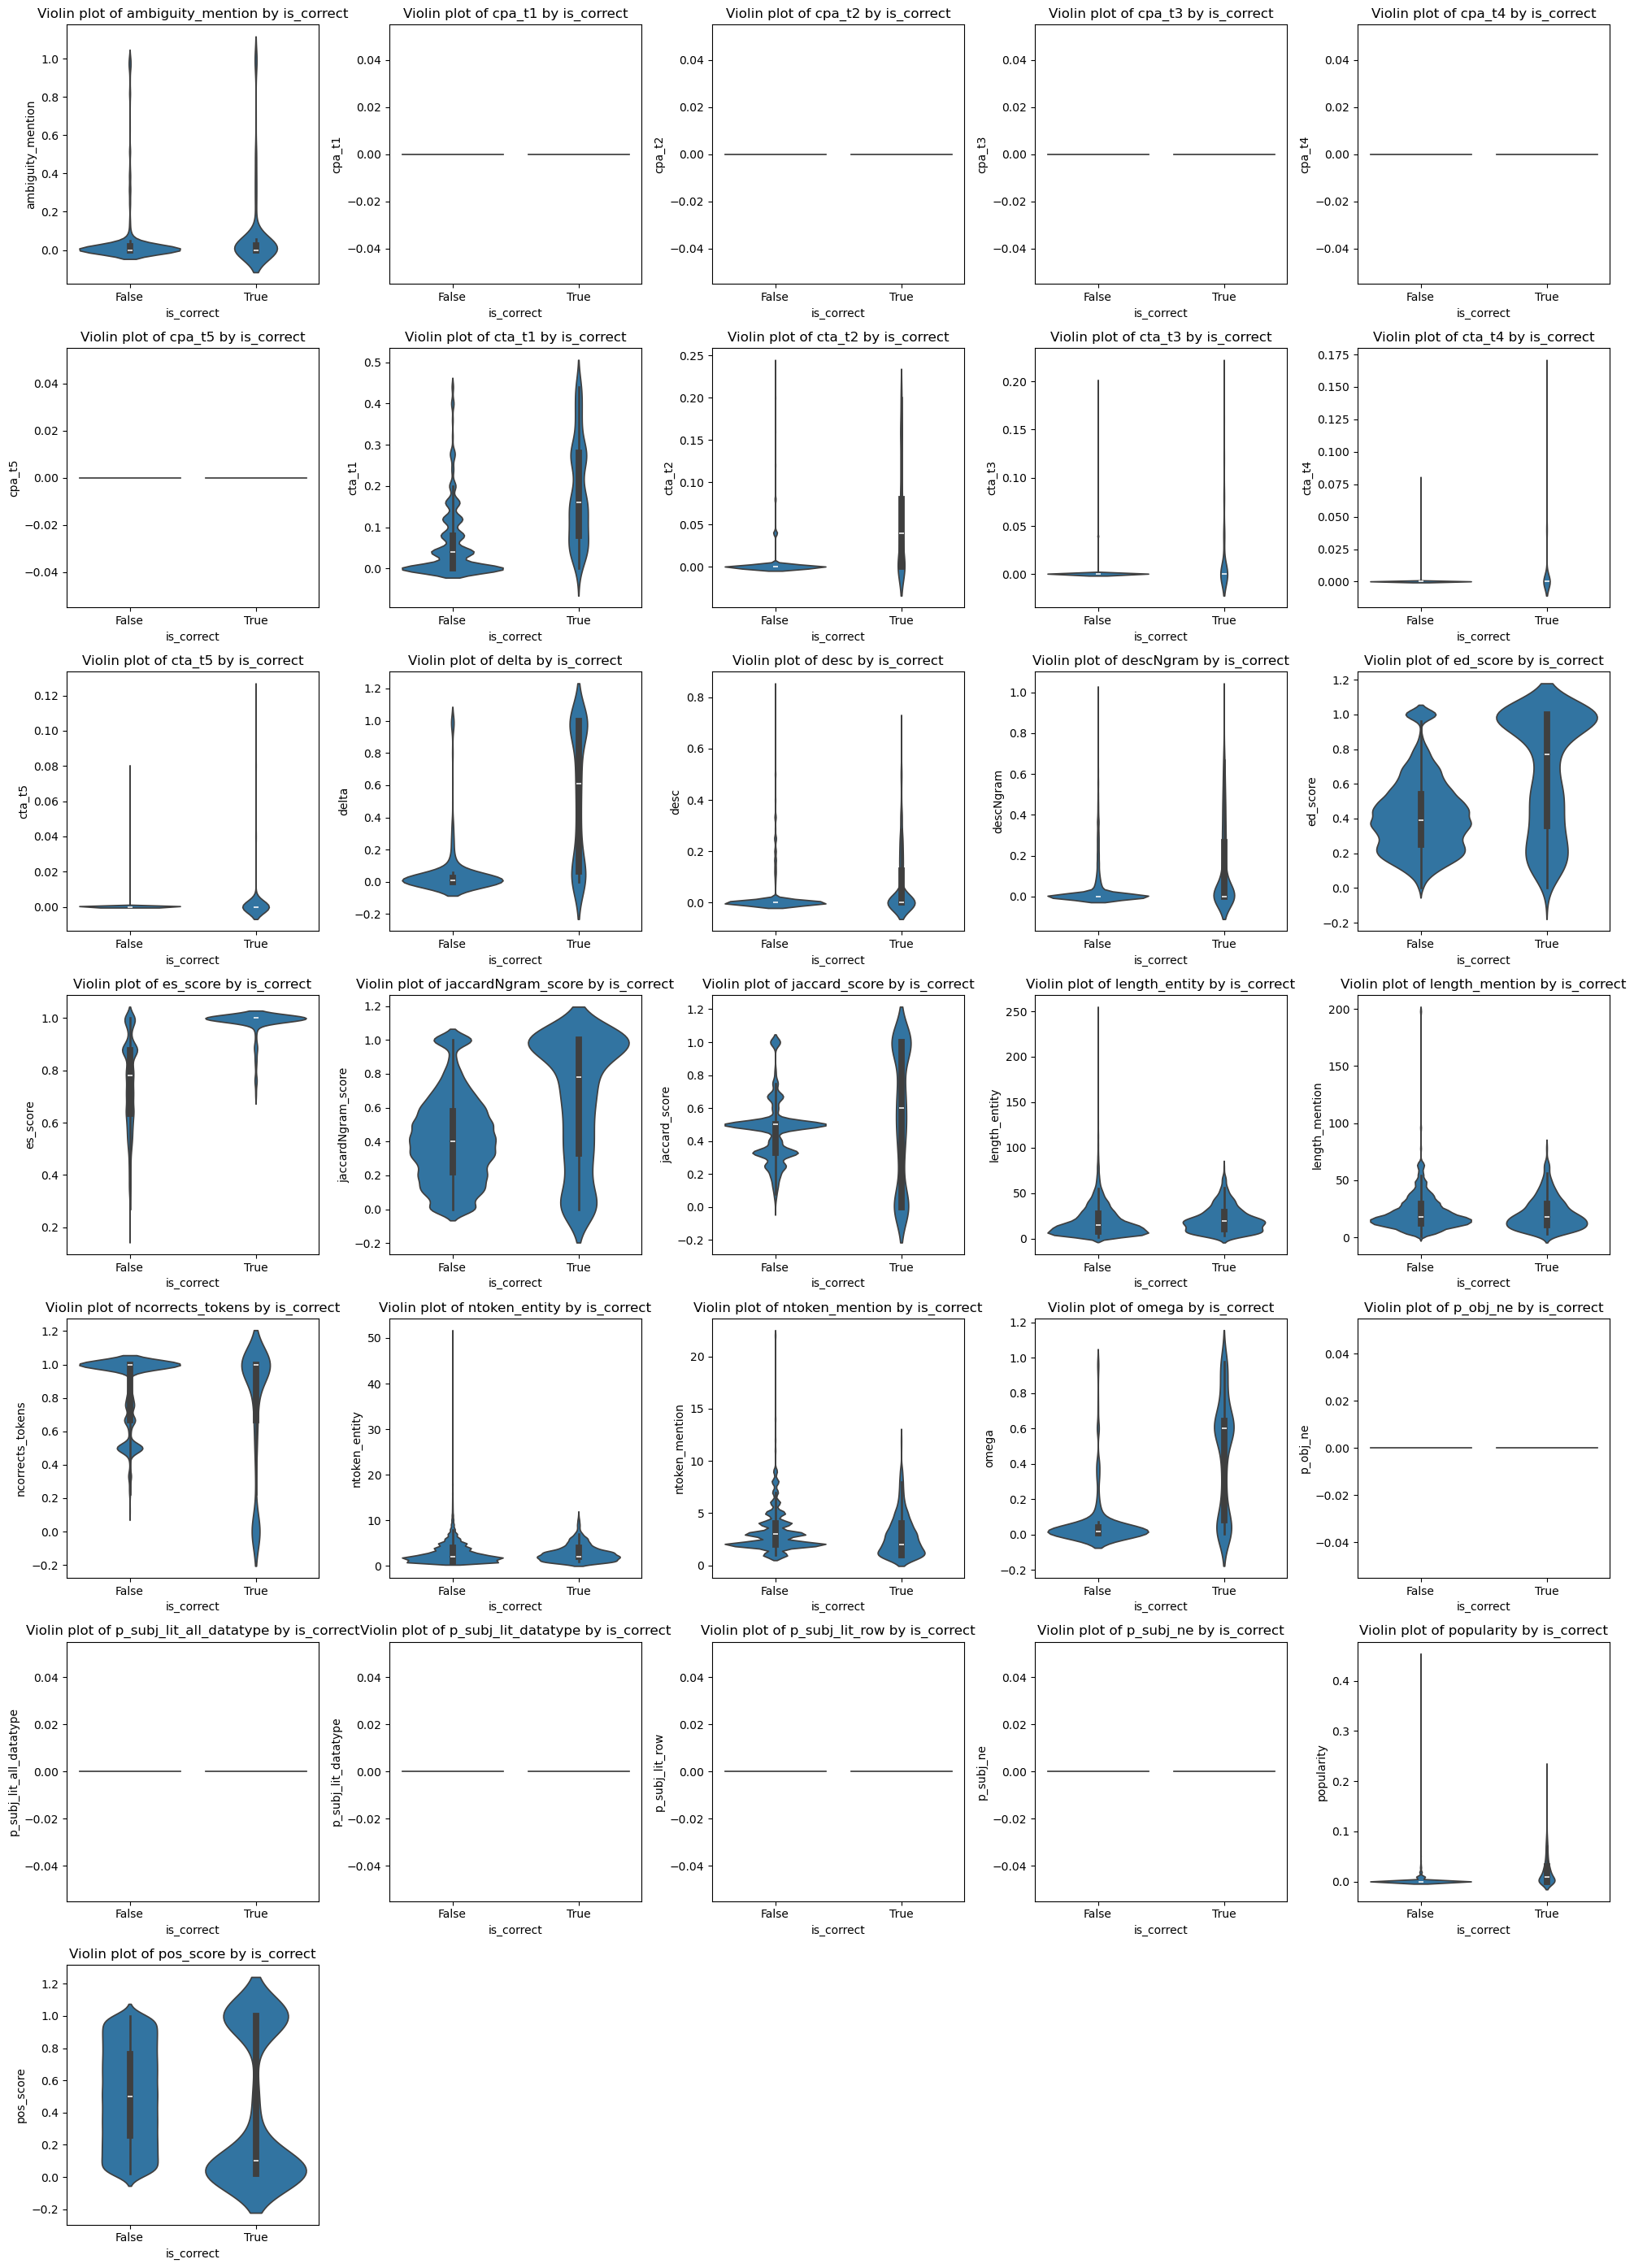

In [109]:
# List of columns to exclude
exclude_columns = ['idRow', 'idColumn', 'index', 'is_correct']

# Get the list of features to plot
features = [col for col in candidate_features.columns if col not in exclude_columns]

# Number of columns in the grid
num_cols = 5
num_rows = math.ceil(len(features) / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create violin plots for each feature
for i, feature in enumerate(features):
    sns.violinplot(x='is_correct', y=feature, data=candidate_features, ax=axes[i])
    axes[i].set_title(f'Violin plot of {feature} by is_correct')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [110]:
import scipy.stats as stats
from sklearn import preprocessing

In [112]:
le = preprocessing.LabelEncoder()
encded_is_correct = le.fit_transform(candidate_features['is_correct'])
le.classes_

array([False,  True])

In [118]:
# percentage of NA values in each column
candidate_features.isnull().mean()


ambiguity_mention          0.00000
cpa_t1                     0.00000
cpa_t2                     0.00000
cpa_t3                     0.00000
cpa_t4                     0.00000
cpa_t5                     0.00000
cta_t1                     0.00000
cta_t2                     0.00000
cta_t3                     0.00000
cta_t4                     0.00000
cta_t5                     0.00000
delta                      0.94934
desc                       0.00000
descNgram                  0.00000
ed_score                   0.00000
es_score                   0.00000
jaccardNgram_score         0.00000
jaccard_score              0.00000
length_entity              0.00000
length_mention             0.00000
ncorrects_tokens           0.00000
ntoken_entity              0.00000
ntoken_mention             0.00000
omega                      0.94934
p_obj_ne                   0.00000
p_subj_lit_all_datatype    0.00000
p_subj_lit_datatype        0.00000
p_subj_lit_row             0.00000
p_subj_ne           

In [116]:
# Nan values in encded_is_correct
# np.isnan(encded_is_correct).sum()

# nan values in candidate_features delta
np.isnan(candidate_features['delta']).sum() 


27622

In [113]:
stats.pointbiserialr(encded_is_correct, candidate_features['delta'])

ValueError: array must not contain infs or NaNs

The selected candidates or the candidate with the highest score assigned by Alligator have been selected. Their features are analyzed in this section.

Most Important note to consider is that **Features belong to the highest scored candidate not the correct one**

## Feature Statistical Params
- Popularity has very low range, 0 - 0.2 => Maybe this meta data is very irrelevant?
- cta1 has more range than the other 4 but its on the lower end, considering our use case this feature is important since it can use the types to filter non ORG candidates => Let's see how it correlates with Match.
- cpa is almost 0 for for every case, this might be rooted in the fact that entities differ in the organization data.

In [30]:
extract_distribution_statistics(github_testset_features).sort_index()

mean    std_dev    min     25%  median  \
ambiguity_mention         0.082617   0.216246  0.000   0.000   0.000   
cpa_t1                    0.000000   0.000000  0.000   0.000   0.000   
cpa_t2                    0.000000   0.000000  0.000   0.000   0.000   
cpa_t3                    0.000000   0.000000  0.000   0.000   0.000   
cpa_t4                    0.000000   0.000000  0.000   0.000   0.000   
cpa_t5                    0.000000   0.000000  0.000   0.000   0.000   
cta_t1                    0.156915   0.128630  0.000   0.040   0.120   
cta_t2                    0.031444   0.056043  0.000   0.000   0.000   
cta_t3                    0.010648   0.033551  0.000   0.000   0.000   
cta_t4                    0.003474   0.014492  0.000   0.000   0.000   
cta_t5                    0.001972   0.012266  0.000   0.000   0.000   
delta                     0.217127   0.347573  0.000   0.004   0.020   
desc                      0.041542   0.096869  0.000   0.000   0.000   
descNgram                 0.093657   0.175127  0.000   0.000   0.000   
ed_score                  0.665117   0.289296  0.030   0.430   0.670   
es_score                  0.983711   0.046952  0.679   1.000   1.000   
jaccardNgram_score        0.660211   0.317800  0.000   0.400   0.670   
jaccard_score             0.608451   0.305580  0.000   0.500   0.500   
length_entity            16.143192  15.536088  2.000   6.250  13.000   
length_mention           19.887324  15.284178  3.000  11.000  16.000   
ncorrects_tokens          0.829613   0.277074  0.000   0.667   1.000   
ntoken_entity             2.314554   2.424313  1.000   1.000   2.000   
ntoken_mention            2.830986   1.960691  1.000   2.000   2.000   
omega                     0.203984   0.292901  0.000   0.012   0.029   
p_obj_ne                  0.000000   0.000000  0.000   0.000   0.000   
p_subj_lit_all_datatype   0.000000   0.000000  0.000   0.000   0.000   
p_subj_lit_datatype       0.000000   0.000000  0.000   0.000   0.000   
p_subj_lit_row            0.000000   0.000000  0.000   0.000   0.000   
p_subj_ne                 0.000000   0.000000  0.000   0.000   0.000   
popularity                0.009906   0.020580  0.000   0.000   0.000   
pos_score                 0.151469   0.291278  0.020   0.020   0.020   

                              75%      max  
ambiguity_mention         0.02300    1.000  
cpa_t1                    0.00000    0.000  
cpa_t2                    0.00000    0.000  
cpa_t3                    0.00000    0.000  
cpa_t4                    0.00000    0.000  
cpa_t5                    0.00000    0.000  
cta_t1                    0.24000    0.480  
cta_t2                    0.04000    0.280  
cta_t3                    0.00000    0.240  
cta_t4                    0.00000    0.120  
cta_t5                    0.00000    0.120  
delta                     0.25025    1.000  
desc                      0.00000    0.500  
descNgram                 0.09100    0.842  
ed_score                  1.00000    1.000  
es_score                  1.00000    1.000  
jaccardNgram_score        1.00000    1.000  
jaccard_score             1.00000    1.000  
length_entity            22.00000  242.000  
length_mention           25.00000  198.000  
ncorrects_tokens          1.00000    1.000  
ntoken_entity             3.00000   43.000  
ntoken_mention            4.00000   22.000  
omega                     0.36625    0.974  
p_obj_ne                  0.00000    0.000  
p_subj_lit_all_datatype   0.00000    0.000  
p_subj_lit_datatype       0.00000    0.000  
p_subj_lit_row            0.00000    0.000  
p_subj_ne                 0.00000    0.000  
popularity                0.01000    0.220  
pos_score                 0.08000    1.000

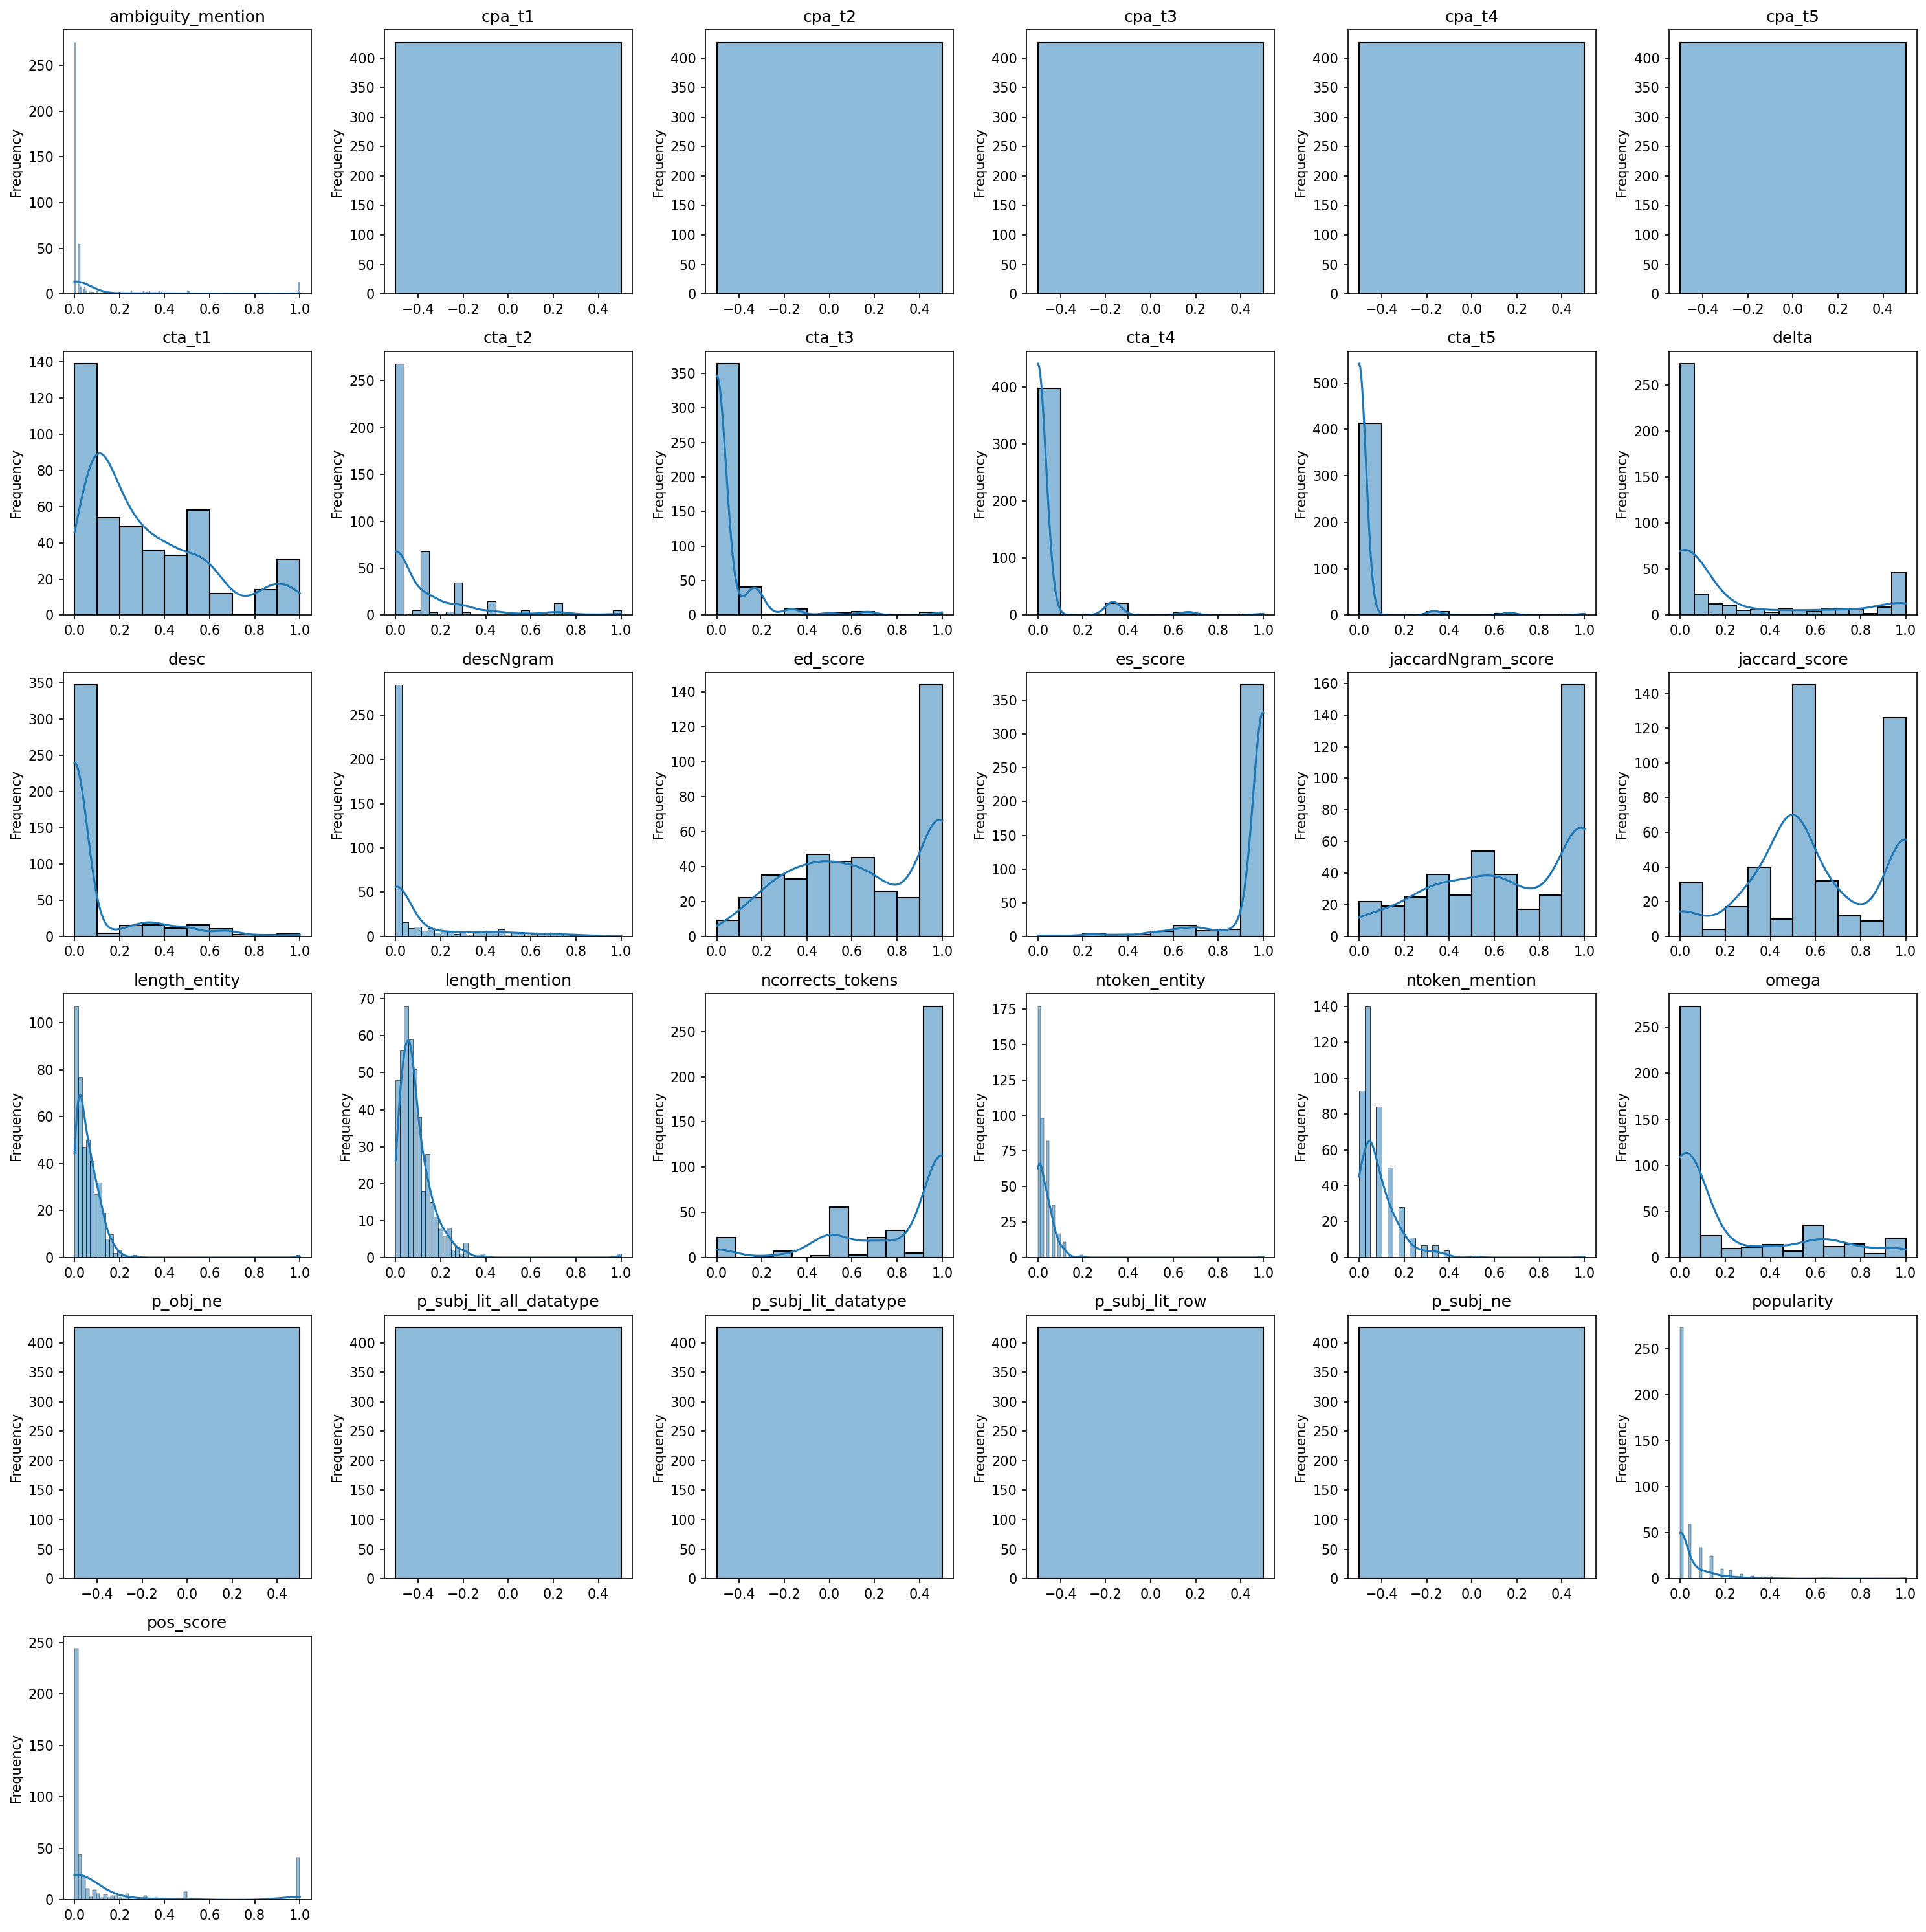

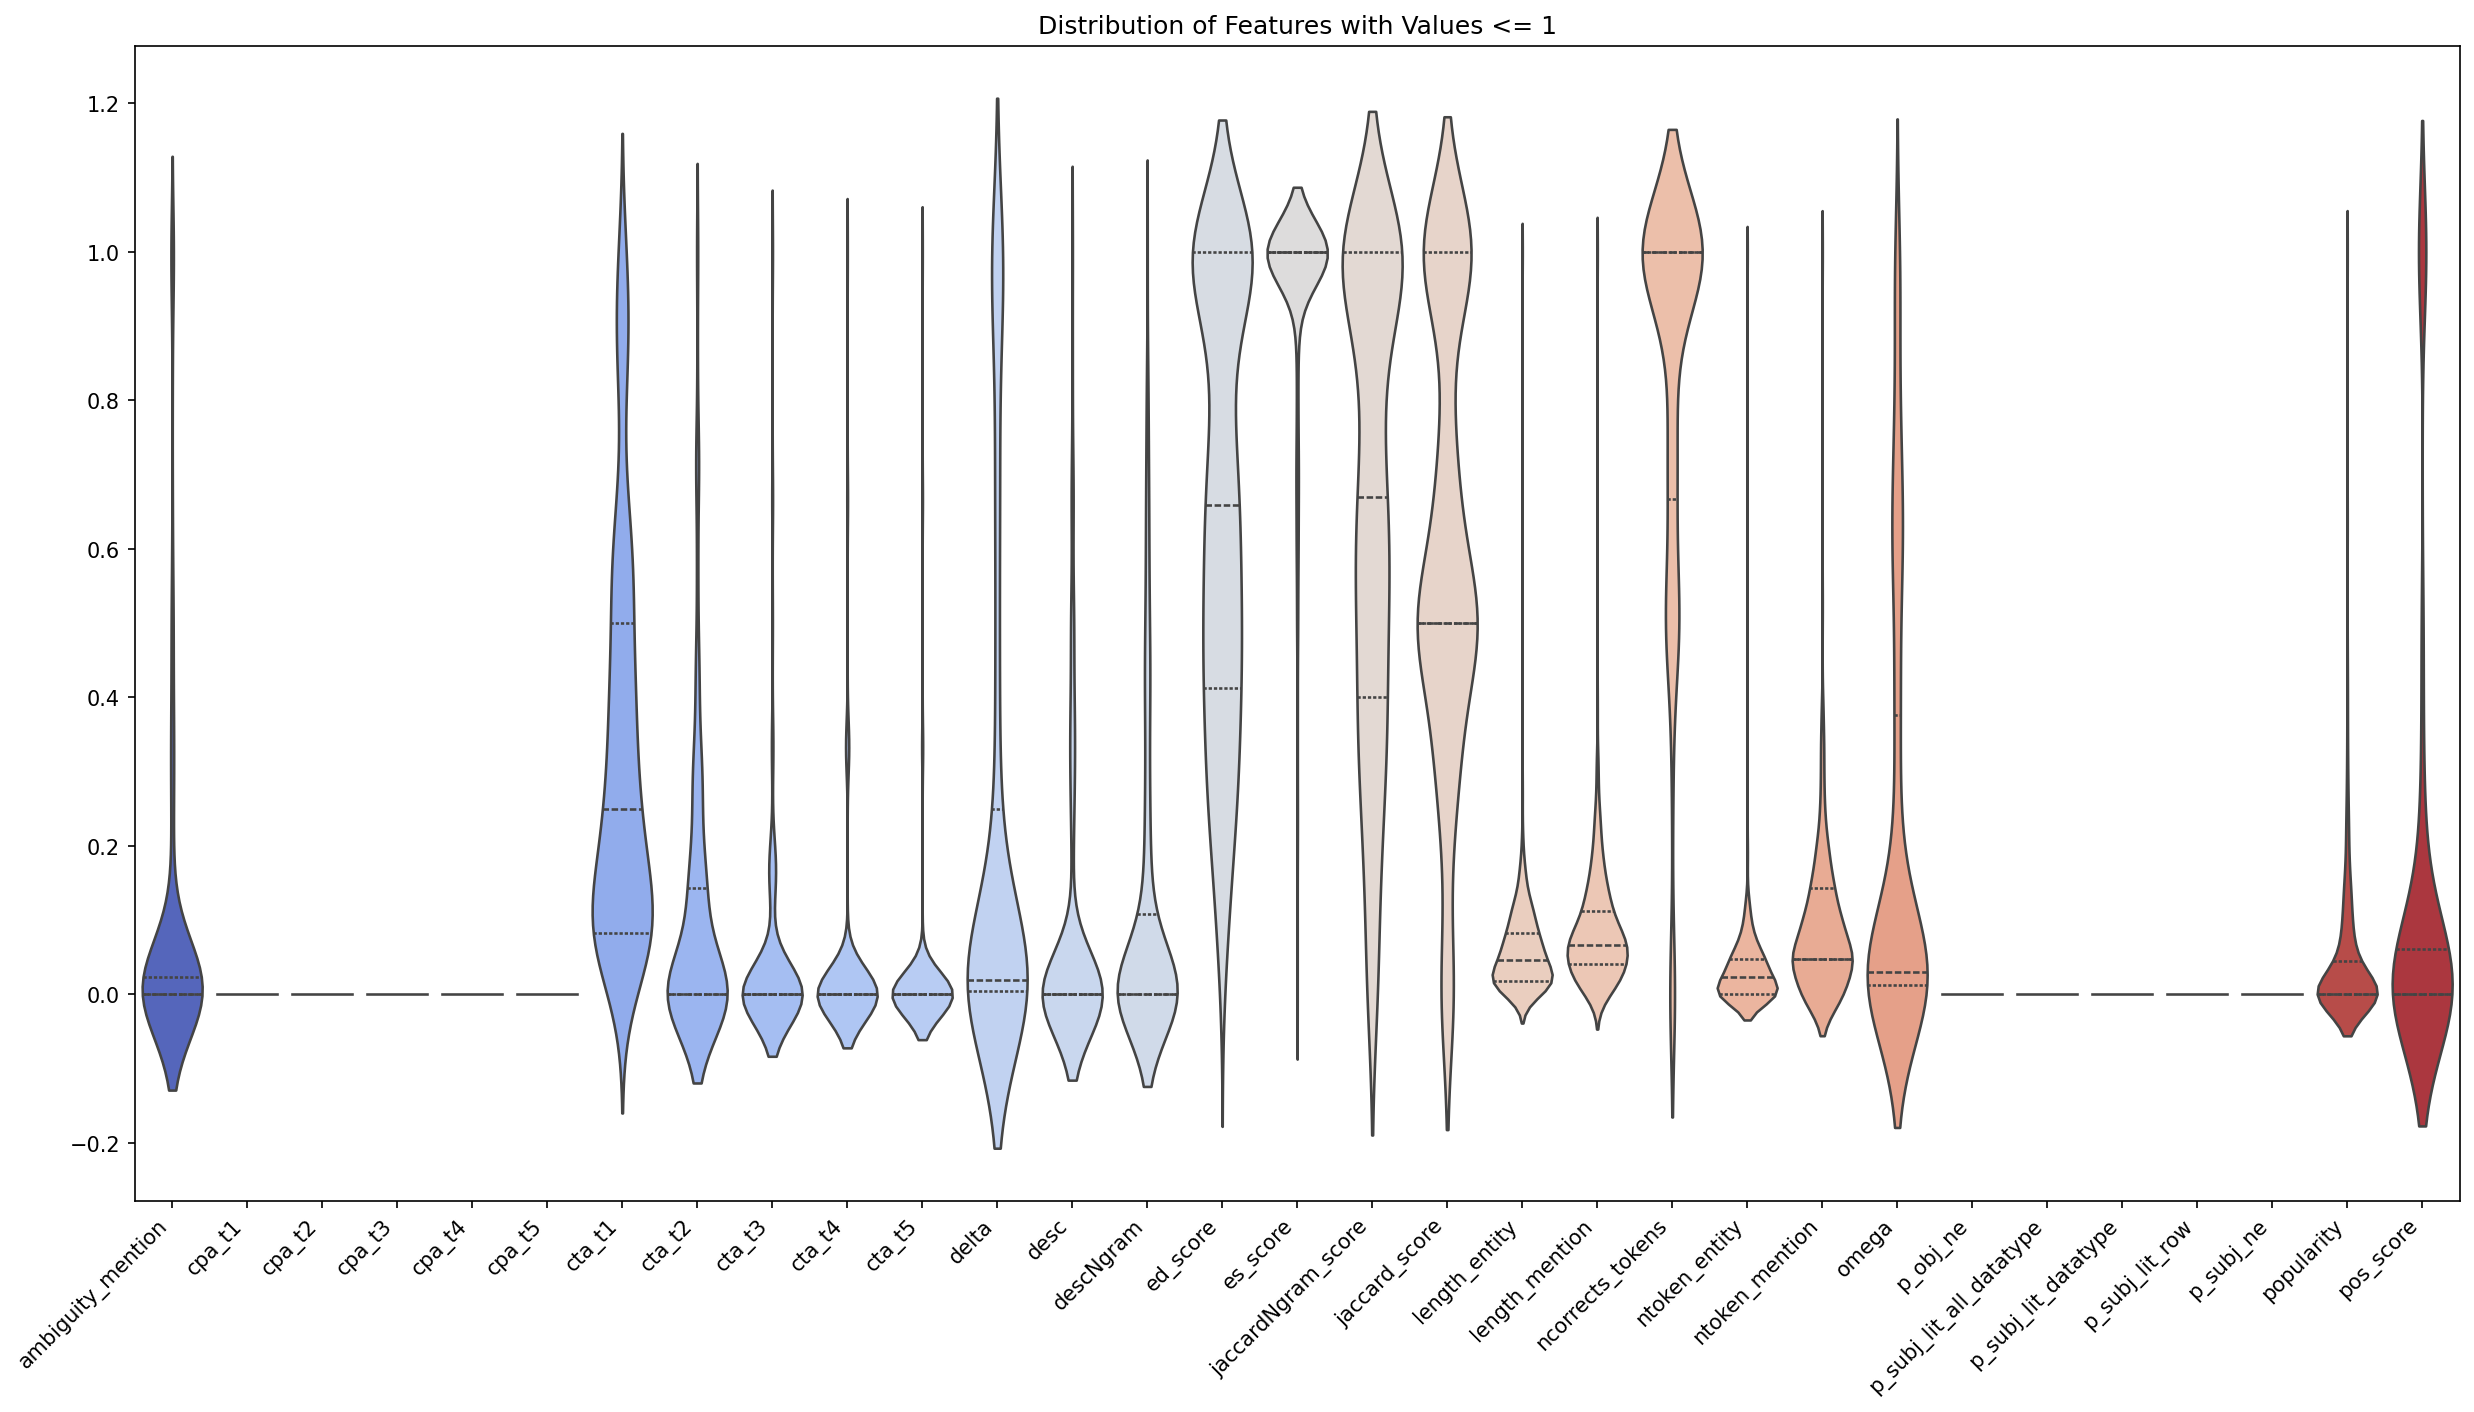

In [35]:
github_testset_features_normalized = normalize_features(github_testset_features).sort_index(axis=1)
plot_feature_distributions(github_testset_features_normalized)

In [38]:
# plot_feature_distributions(github_testset_features)

# Feature Statistics in Github Data

In [7]:
all_gh_data_features_path = "B:/Projects/Alligator-2/alligator/Github_Data/github_features.csv"
features_df = pd.read_csv(all_gh_data_features_path, index_col="key").drop(columns=["delta", "omega"])
features_df.sort_index(axis=1, inplace=True)

In [8]:
extract_distribution_statistics(features_df)

mean    std_dev    min   25%  median     75%  \
ambiguity_mention         0.128346   0.256206  0.000  0.00   0.022   0.093   
cpa_t1                    0.021254   0.046103  0.000  0.00   0.000   0.015   
cpa_t2                    0.003394   0.013246  0.000  0.00   0.000   0.000   
cpa_t3                    0.000374   0.002812  0.000  0.00   0.000   0.000   
cpa_t4                    0.000014   0.000381  0.000  0.00   0.000   0.000   
cpa_t5                    0.000003   0.000177  0.000  0.00   0.000   0.000   
cta_t1                    0.133393   0.109787  0.000  0.04   0.120   0.200   
cta_t2                    0.042836   0.076461  0.000  0.00   0.000   0.080   
cta_t3                    0.017576   0.036532  0.000  0.00   0.000   0.040   
cta_t4                    0.007010   0.020316  0.000  0.00   0.000   0.000   
cta_t5                    0.003050   0.013136  0.000  0.00   0.000   0.000   
desc                      0.052564   0.097563  0.000  0.00   0.000   0.111   
descNgram                 0.106423   0.161463  0.000  0.00   0.000   0.205   
ed_score                  0.787915   0.273175  0.010  0.57   1.000   1.000   
es_score                  0.985499   0.046029  0.412  1.00   1.000   1.000   
jaccardNgram_score        0.786829   0.295538  0.000  0.58   1.000   1.000   
jaccard_score             0.779501   0.266219  0.000  0.50   1.000   1.000   
length_entity            16.895064  12.388215  1.000  7.00  15.000  24.000   
length_mention           19.529837  13.864502  1.000  9.00  17.000  26.000   
ncorrects_tokens          0.925515   0.168699  0.053  1.00   1.000   1.000   
ntoken_entity             2.349682   1.555922  1.000  1.00   2.000   3.000   
ntoken_mention            2.742671   1.811011  1.000  1.00   2.000   3.000   
p_obj_ne                  0.000000   0.000000  0.000  0.00   0.000   0.000   
p_subj_lit_all_datatype   0.000000   0.000000  0.000  0.00   0.000   0.000   
p_subj_lit_datatype       0.153960   0.276369  0.000  0.00   0.000   0.171   
p_subj_lit_row            0.073157   0.103436  0.000  0.00   0.031   0.100   
p_subj_ne                 0.000000   0.000000  0.000  0.00   0.000   0.000   
popularity                0.023062   0.044573  0.000  0.00   0.000   0.030   
pos_score                 0.086683   0.191037  0.020  0.02   0.020   0.043   

                             max  
ambiguity_mention          1.000  
cpa_t1                     0.487  
cpa_t2                     0.348  
cpa_t3                     0.122  
cpa_t4                     0.036  
cpa_t5                     0.033  
cta_t1                     1.000  
cta_t2                     1.000  
cta_t3                     0.320  
cta_t4                     0.280  
cta_t5                     0.240  
desc                       0.778  
descNgram                  0.800  
ed_score                   1.000  
es_score                   1.000  
jaccardNgram_score         1.000  
jaccard_score              1.000  
length_entity            242.000  
length_mention           276.000  
ncorrects_tokens           1.000  
ntoken_entity             43.000  
ntoken_mention            36.000  
p_obj_ne                   0.000  
p_subj_lit_all_datatype    0.000  
p_subj_lit_datatype        1.000  
p_subj_lit_row             0.667  
p_subj_ne                  0.000  
popularity                 0.470  
pos_score                  1.000

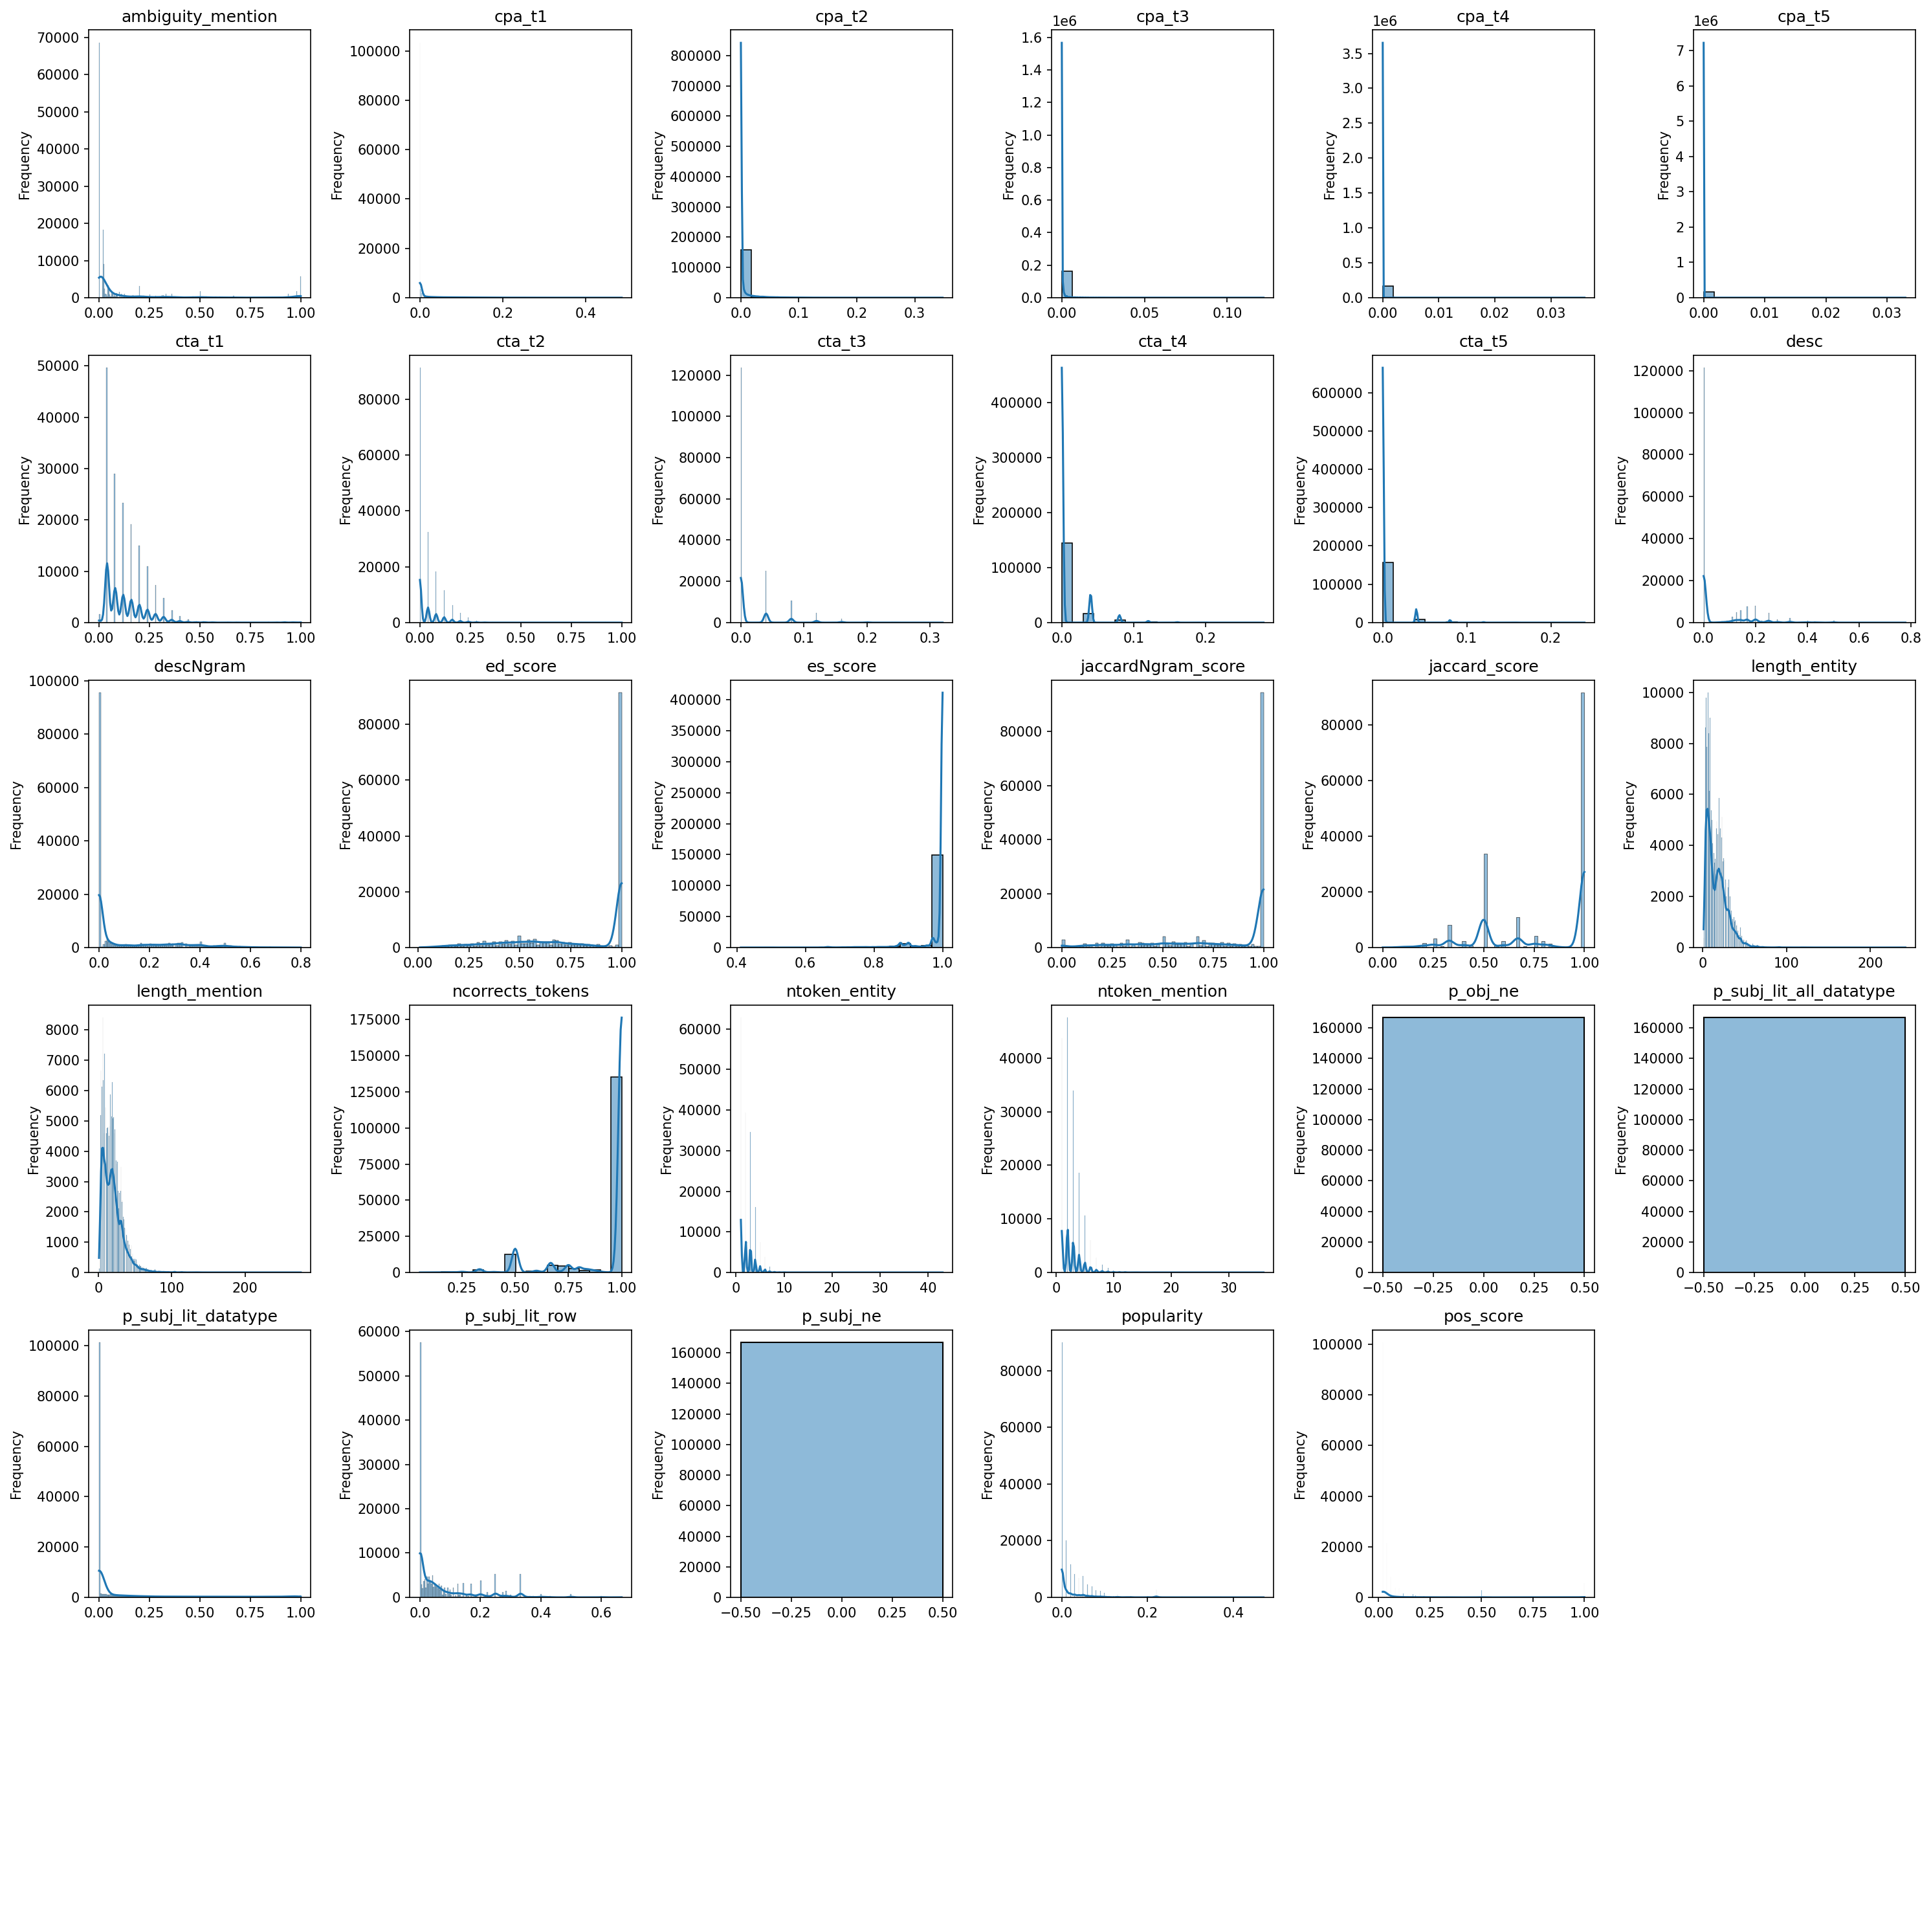

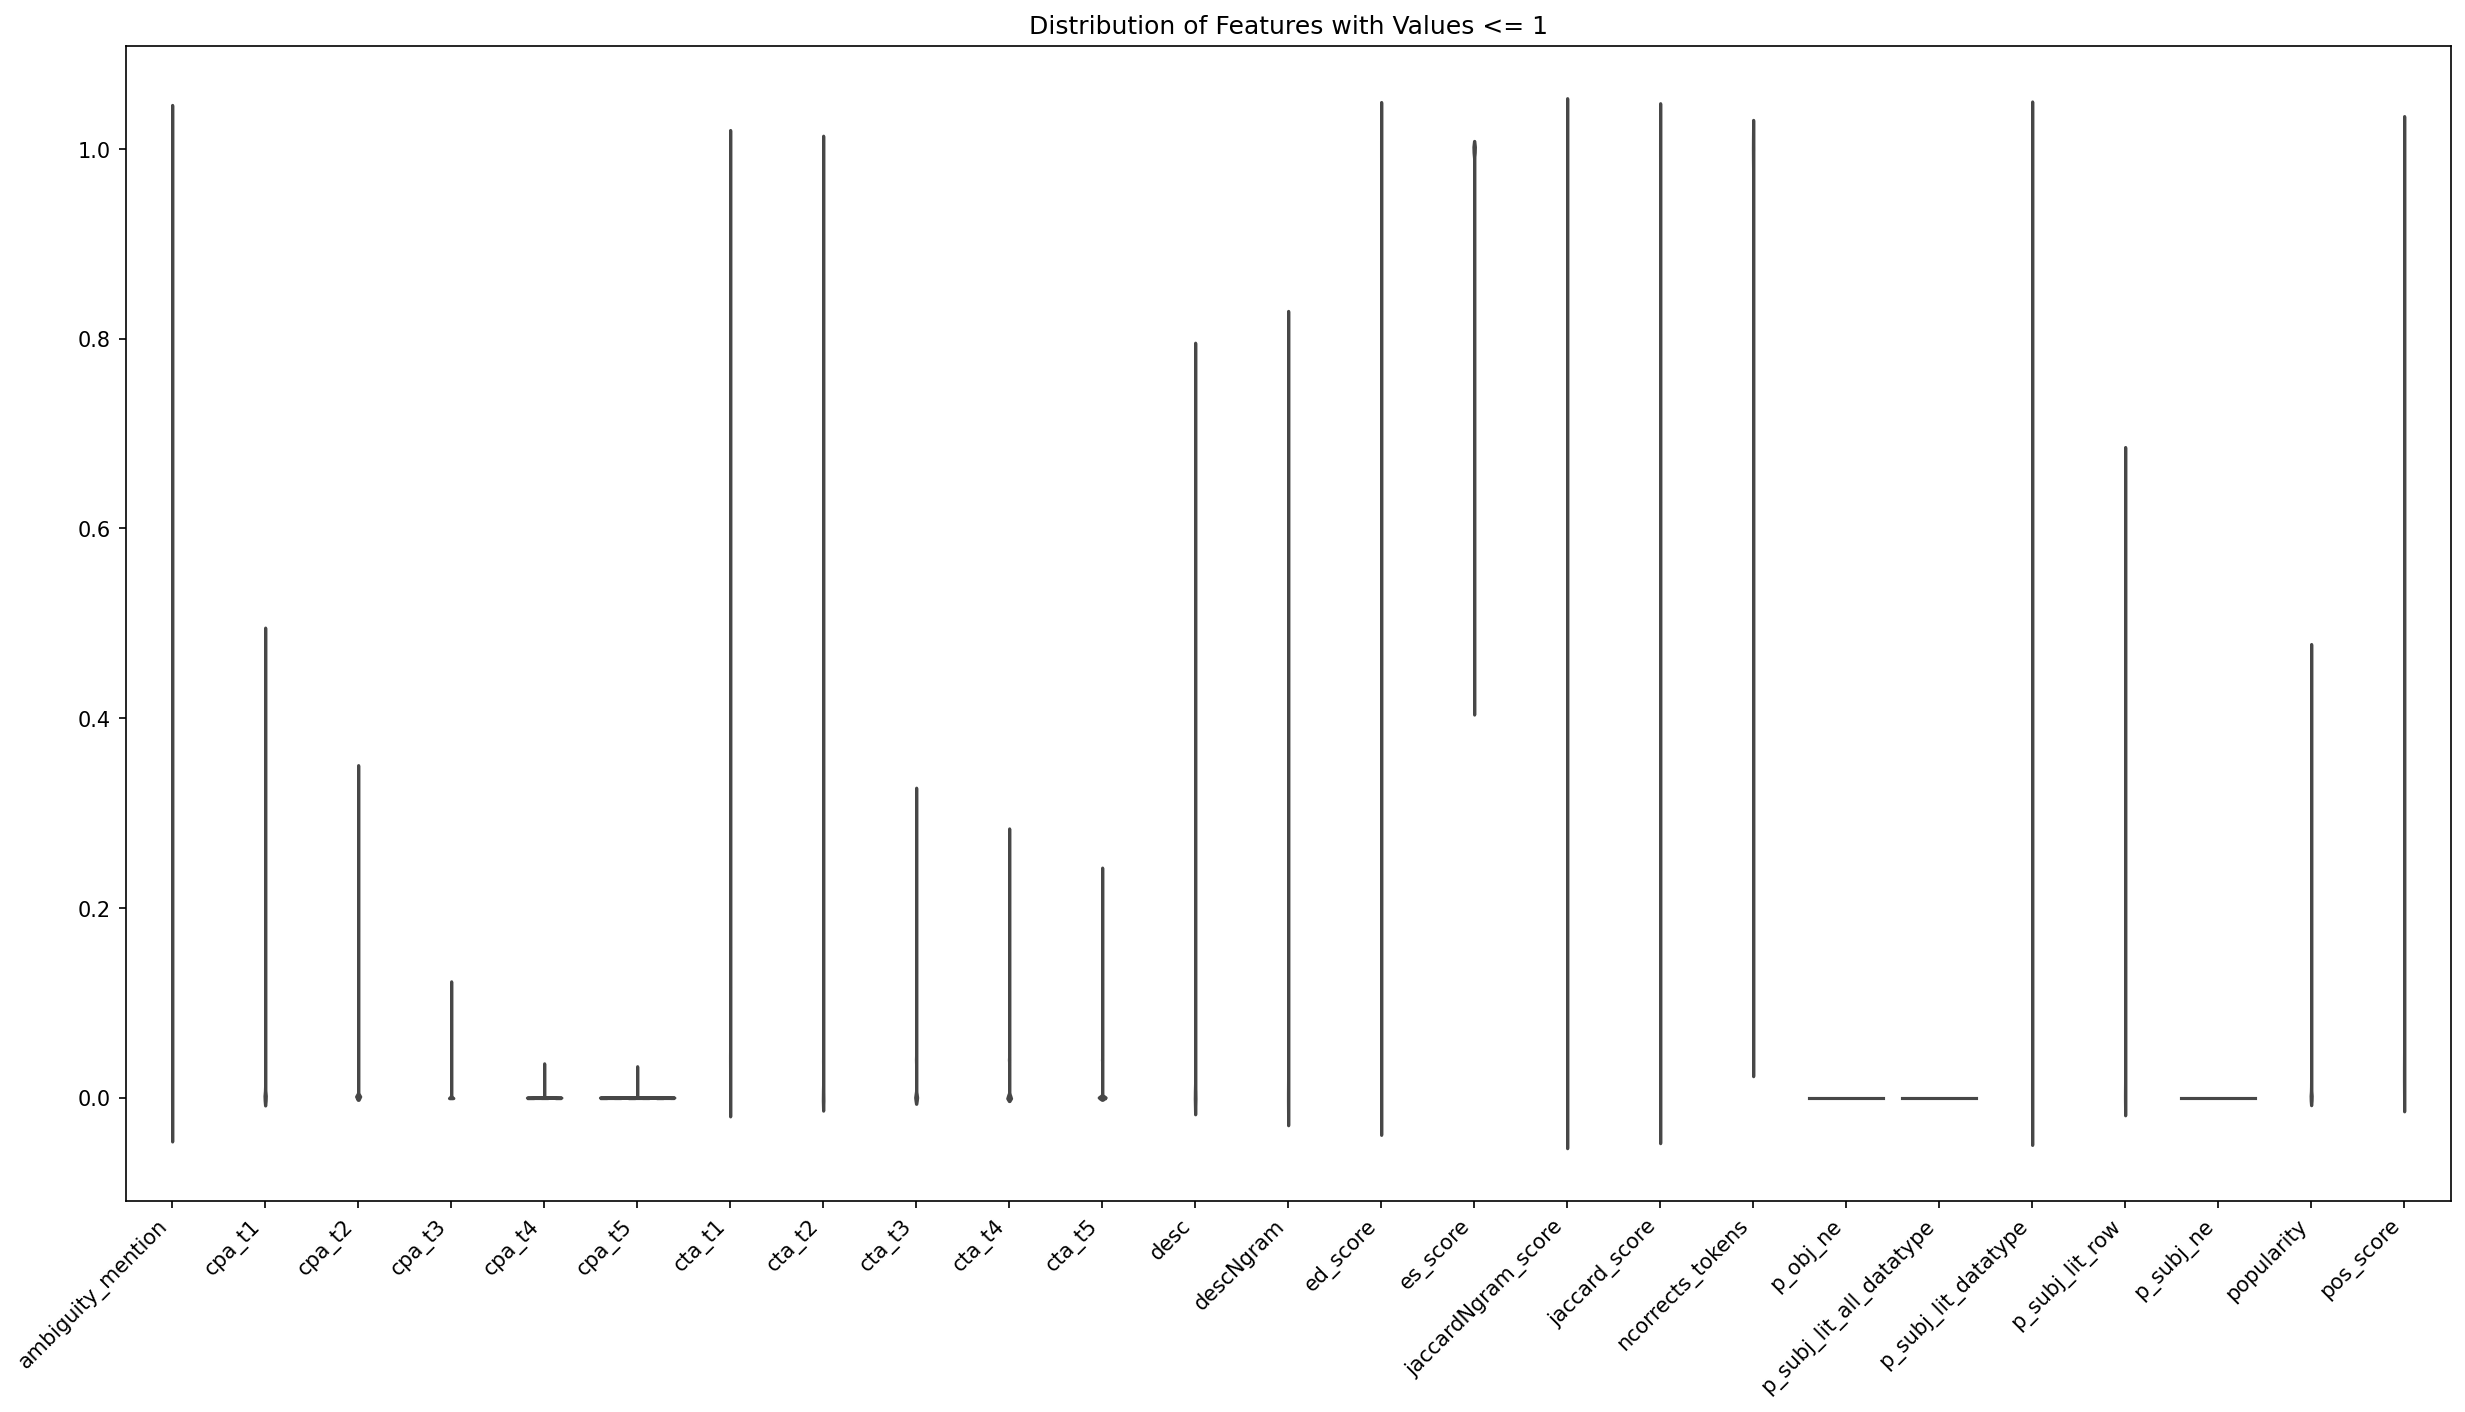

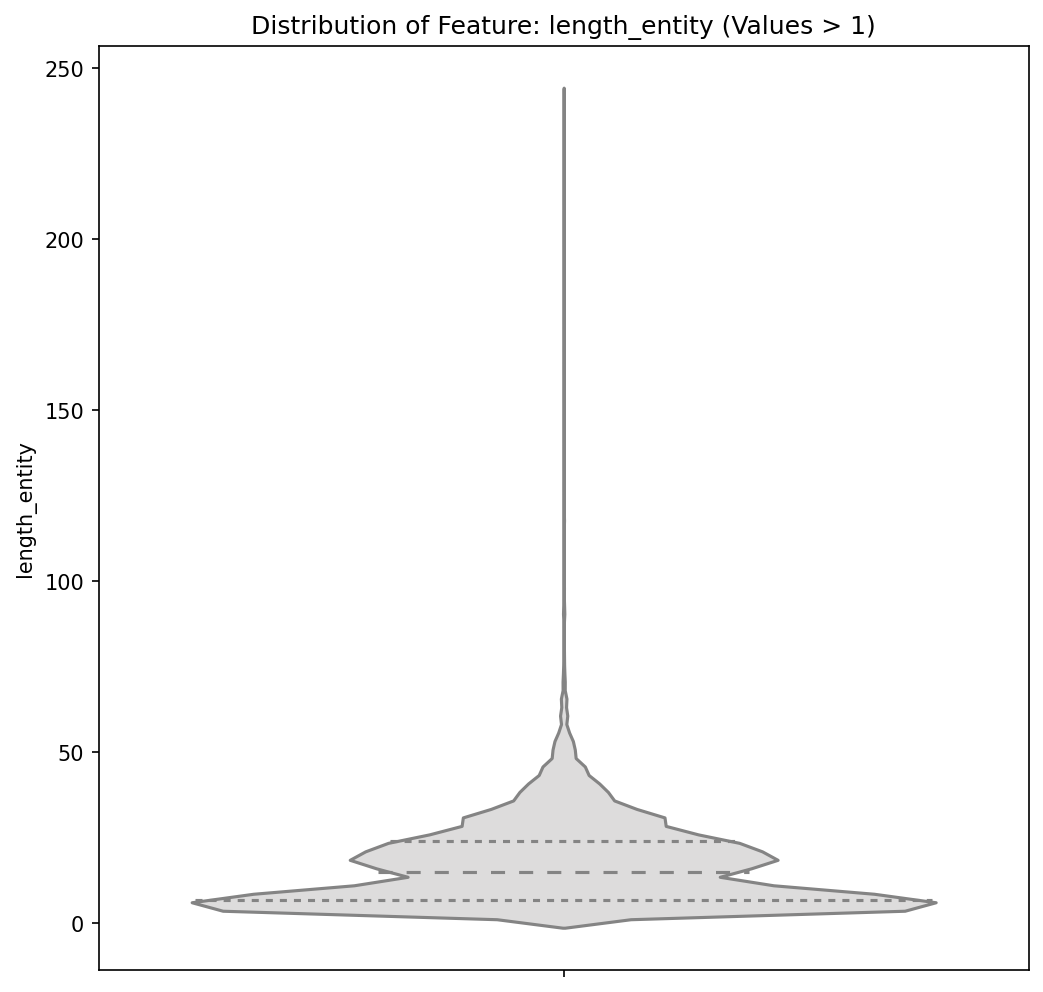

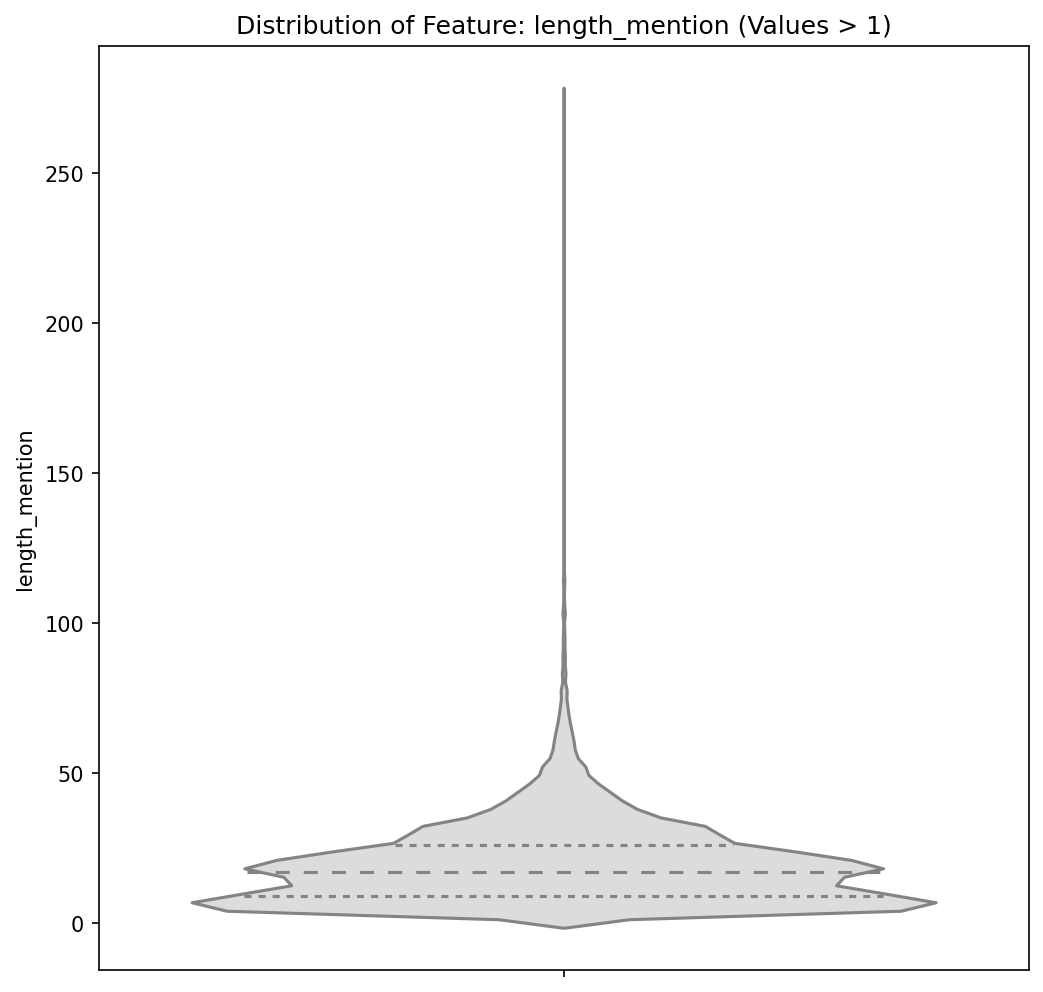

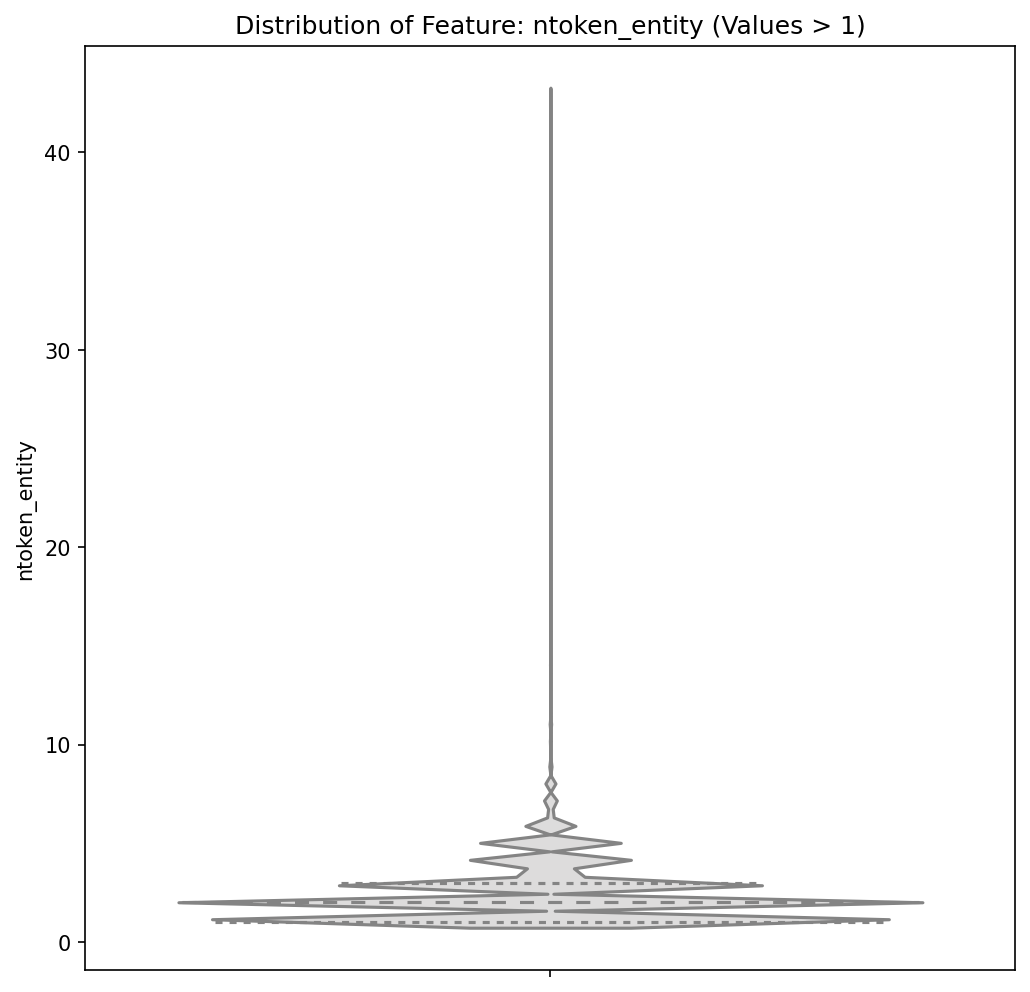

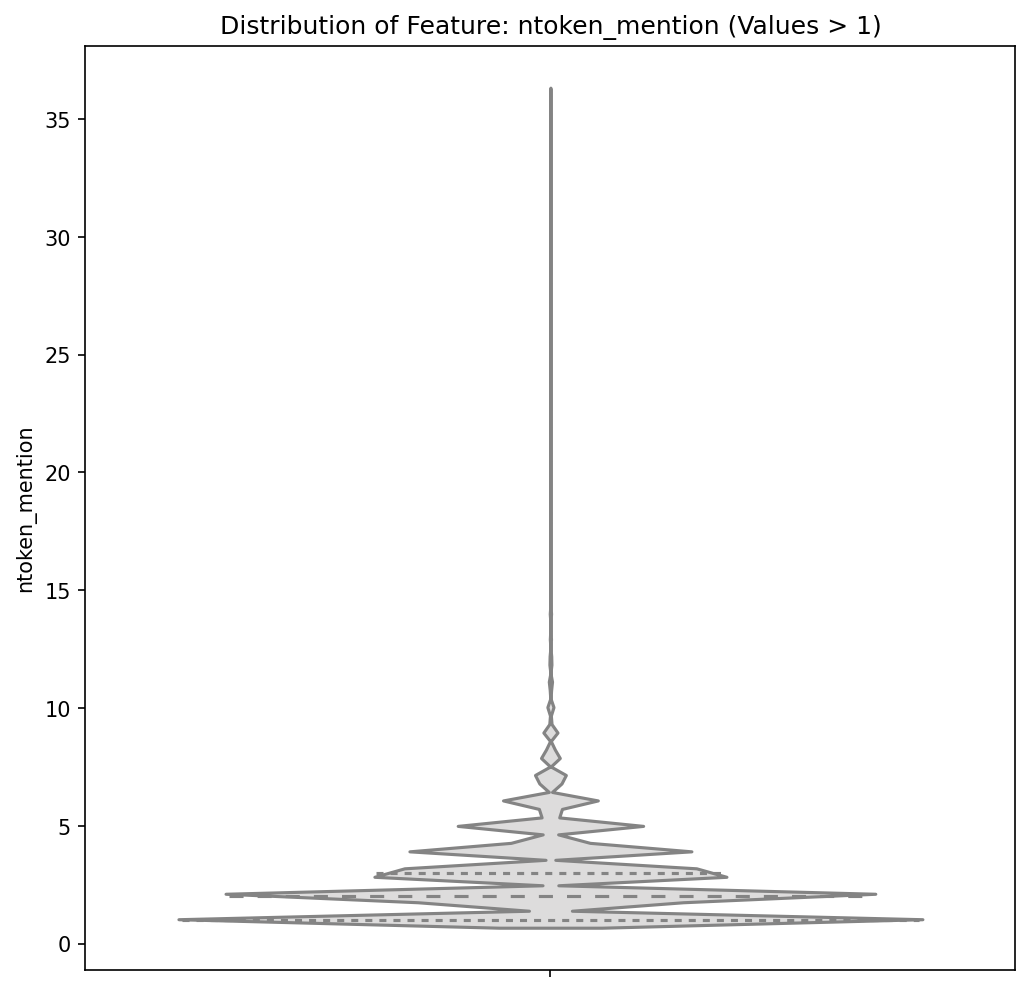

In [9]:
plot_feature_distributions(features_df)

In [10]:
# plot normalized features
normalized_features_df = normalize_features(features_df)
# plot_feature_distributions(normalized_features_df)


In [11]:
# plot_feature_pairwise_scatter(features_df.sample(1000))

In [12]:


# # Load Ground Truth data
# gt_file_path = 'B:/Projects/alligator/gh/gt/cea_gt.csv'
# gt = pd.read_csv(gt_file_path, header=None)
# gt.columns = ["table_name", "row", "col", "qid"]

# # Clean up QIDs from URLs in ground truth
# url_regex = re.compile(r"http(s)?\:////www/.wikidata/.org\/(wiki|entity)\/")
# gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))

# # Create a dictionary for easy lookup of ground truth
# gt_mapping = {
#     f"{row.table_name}-{row.row}-{row.col}": row.qid
#     for row in gt.itertuples()
# }

# # Set parameters
# current_table_name = "Github_Testset"
# threshold = 0.2  # Adjust as necessary

# # Initialize list to store each row's features
# rows = []

# # Loop through each annotation in 'cea' and calculate match
# for annotation in data['semanticAnnotations']['cea']:
#     # Extract the first entity
#     if annotation['entity']:
#         first_entity = annotation['entity'][0]
#         key = f"{current_table_name}-{annotation['idRow']}-{annotation['idColumn']}"

#         # Determine if this entity is a correct match based on ground truth and threshold
#         predicted_qid = first_entity['id'] if first_entity['score'] >= threshold else ""
#         correct_match = 1 if predicted_qid == gt_mapping.get(key) else 0

#         # Extract features and add match status
#         features = {feature['id']: feature['value'] for feature in first_entity['features']}
#         features.update({
#             'idColumn': annotation['idColumn'],
#             'idRow': annotation['idRow'],
#             'entity_id': first_entity['id'],
#             'entity_name': first_entity['name'],
#             'match': correct_match
#         })

#         rows.append(features)

# # Create DataFrame from extracted features
# df = pd.DataFrame(rows)

# # Plot histograms with rows colored based on match status
# features = ['delta', 'omega', 'levenshtein_distance', 'jaccard_distance', 'popularity']

# # Loop through each feature and create a Plotly histogram
# for feature in features:
#     fig = px.histogram(df, x=feature, color='match',
#                        color_discrete_map={1: 'green', 0: 'red'},
#                        nbins=20, range_x=(0, 1), barmode='overlay',
#                        title=f'Distribution of {feature} by Match Status')
#     fig.update_yaxes(title_text="Percentage", range=[0, 100])
#     fig.update_layout(bargap=0.2)
#     fig.show()


# Correct Candidates Distribution of Features

In [ ]:
# correct_candidate_features_gh_testset = extract_correct_features(alligator_annotations_github_testset)
# correct_candidate_features_gh_testset.drop(columns=["idRow", "correct_id", "omega", "delta"], inplace=True)
# correct_candidate_features_gh_testset.sort_index(axis=1, inplace=True)

- ambiguity mention is skewed towards right, almost all mentions are unique and are not mentioned, however there are some that have been repeated. => Considering the usecase, a lot of mentions are very unique however a majority of entities also appear over and over as mentions.
- cpa's have a close to zero variance.
- cta as expected is taking into consideration the types and it is showing a normal distribution.
- descNgram is smoother than desc => considering this usecase, There is only one column and it is expected to be more similar to the label rather than description.
- edscore median is 0.95, more than half of the candidates are almost identical to the entity.
- es_score low std, close to 1 mean. => a comparison with other candidates that are not correct might give more info
- Jaccard and JaccardNGram as the samples of data also suggest, have a normal dist but a sudden increase in one, which I interpret that there are 2 types of mentions, those with accurate name, and those with messed up ones.
- we see low popularities
- pos score highly skewed to right.

In [ ]:
extract_distribution_statistics(correct_candidate_features_gh_testset)

mean    std_dev    min     25%  median     75%  \
ambiguity_mention         0.101985   0.225814  0.000   0.000   0.021   0.043   
cpa_t1                    0.001350   0.006924  0.000   0.000   0.000   0.000   
cpa_t2                    0.000071   0.000576  0.000   0.000   0.000   0.000   
cpa_t3                    0.000010   0.000142  0.000   0.000   0.000   0.000   
cpa_t4                    0.000000   0.000000  0.000   0.000   0.000   0.000   
cpa_t5                    0.000000   0.000000  0.000   0.000   0.000   0.000   
cta_t1                    0.185888   0.130216  0.000   0.080   0.182   0.240   
cta_t2                    0.051117   0.068686  0.000   0.000   0.040   0.080   
cta_t3                    0.018873   0.046535  0.000   0.000   0.000   0.000   
cta_t4                    0.003858   0.015951  0.000   0.000   0.000   0.000   
cta_t5                    0.001827   0.012964  0.000   0.000   0.000   0.000   
desc                      0.067355   0.106089  0.000   0.000   0.000   0.125   
descNgram                 0.133213   0.171423  0.000   0.000   0.023   0.256   
ed_score                  0.775787   0.271058  0.060   0.550   0.950   1.000   
es_score                  0.964046   0.071249  0.717   0.975   1.000   1.000   
jaccardNgram_score        0.786244   0.272996  0.050   0.600   0.950   1.000   
jaccard_score             0.748731   0.255415  0.120   0.500   0.750   1.000   
length_entity            18.751269  12.155206  3.000   9.000  18.000  24.000   
length_mention           22.111675  14.417525  3.000  12.000  18.000  30.000   
ncorrects_tokens          0.948051   0.129381  0.500   1.000   1.000   1.000   
ntoken_entity             2.609137   1.540116  1.000   1.000   2.000   3.000   
ntoken_mention            3.131980   1.951672  1.000   2.000   3.000   4.000   
p_obj_ne                  0.000000   0.000000  0.000   0.000   0.000   0.000   
p_subj_lit_all_datatype   0.000000   0.000000  0.000   0.000   0.000   0.000   
p_subj_lit_datatype       0.054467   0.180451  0.000   0.000   0.000   0.001   
p_subj_lit_row            0.058670   0.069962  0.000   0.000   0.040   0.077   
p_subj_ne                 0.000000   0.000000  0.000   0.000   0.000   0.000   
popularity                0.019543   0.027725  0.000   0.000   0.010   0.030   
pos_score                 0.138975   0.226173  0.020   0.020   0.040   0.140   

                            max  
ambiguity_mention         1.000  
cpa_t1                    0.057  
cpa_t2                    0.006  
cpa_t3                    0.002  
cpa_t4                    0.000  
cpa_t5                    0.000  
cta_t1                    0.440  
cta_t2                    0.280  
cta_t3                    0.240  
cta_t4                    0.120  
cta_t5                    0.120  
desc                      0.500  
descNgram                 0.649  
ed_score                  1.000  
es_score                  1.000  
jaccardNgram_score        1.000  
jaccard_score             1.000  
length_entity            67.000  
length_mention           78.000  
ncorrects_tokens          1.000  
ntoken_entity             9.000  
ntoken_mention           12.000  
p_obj_ne                  0.000  
p_subj_lit_all_datatype   0.000  
p_subj_lit_datatype       0.994  
p_subj_lit_row            0.375  
p_subj_ne                 0.000  
popularity                0.220  
pos_score                 1.000

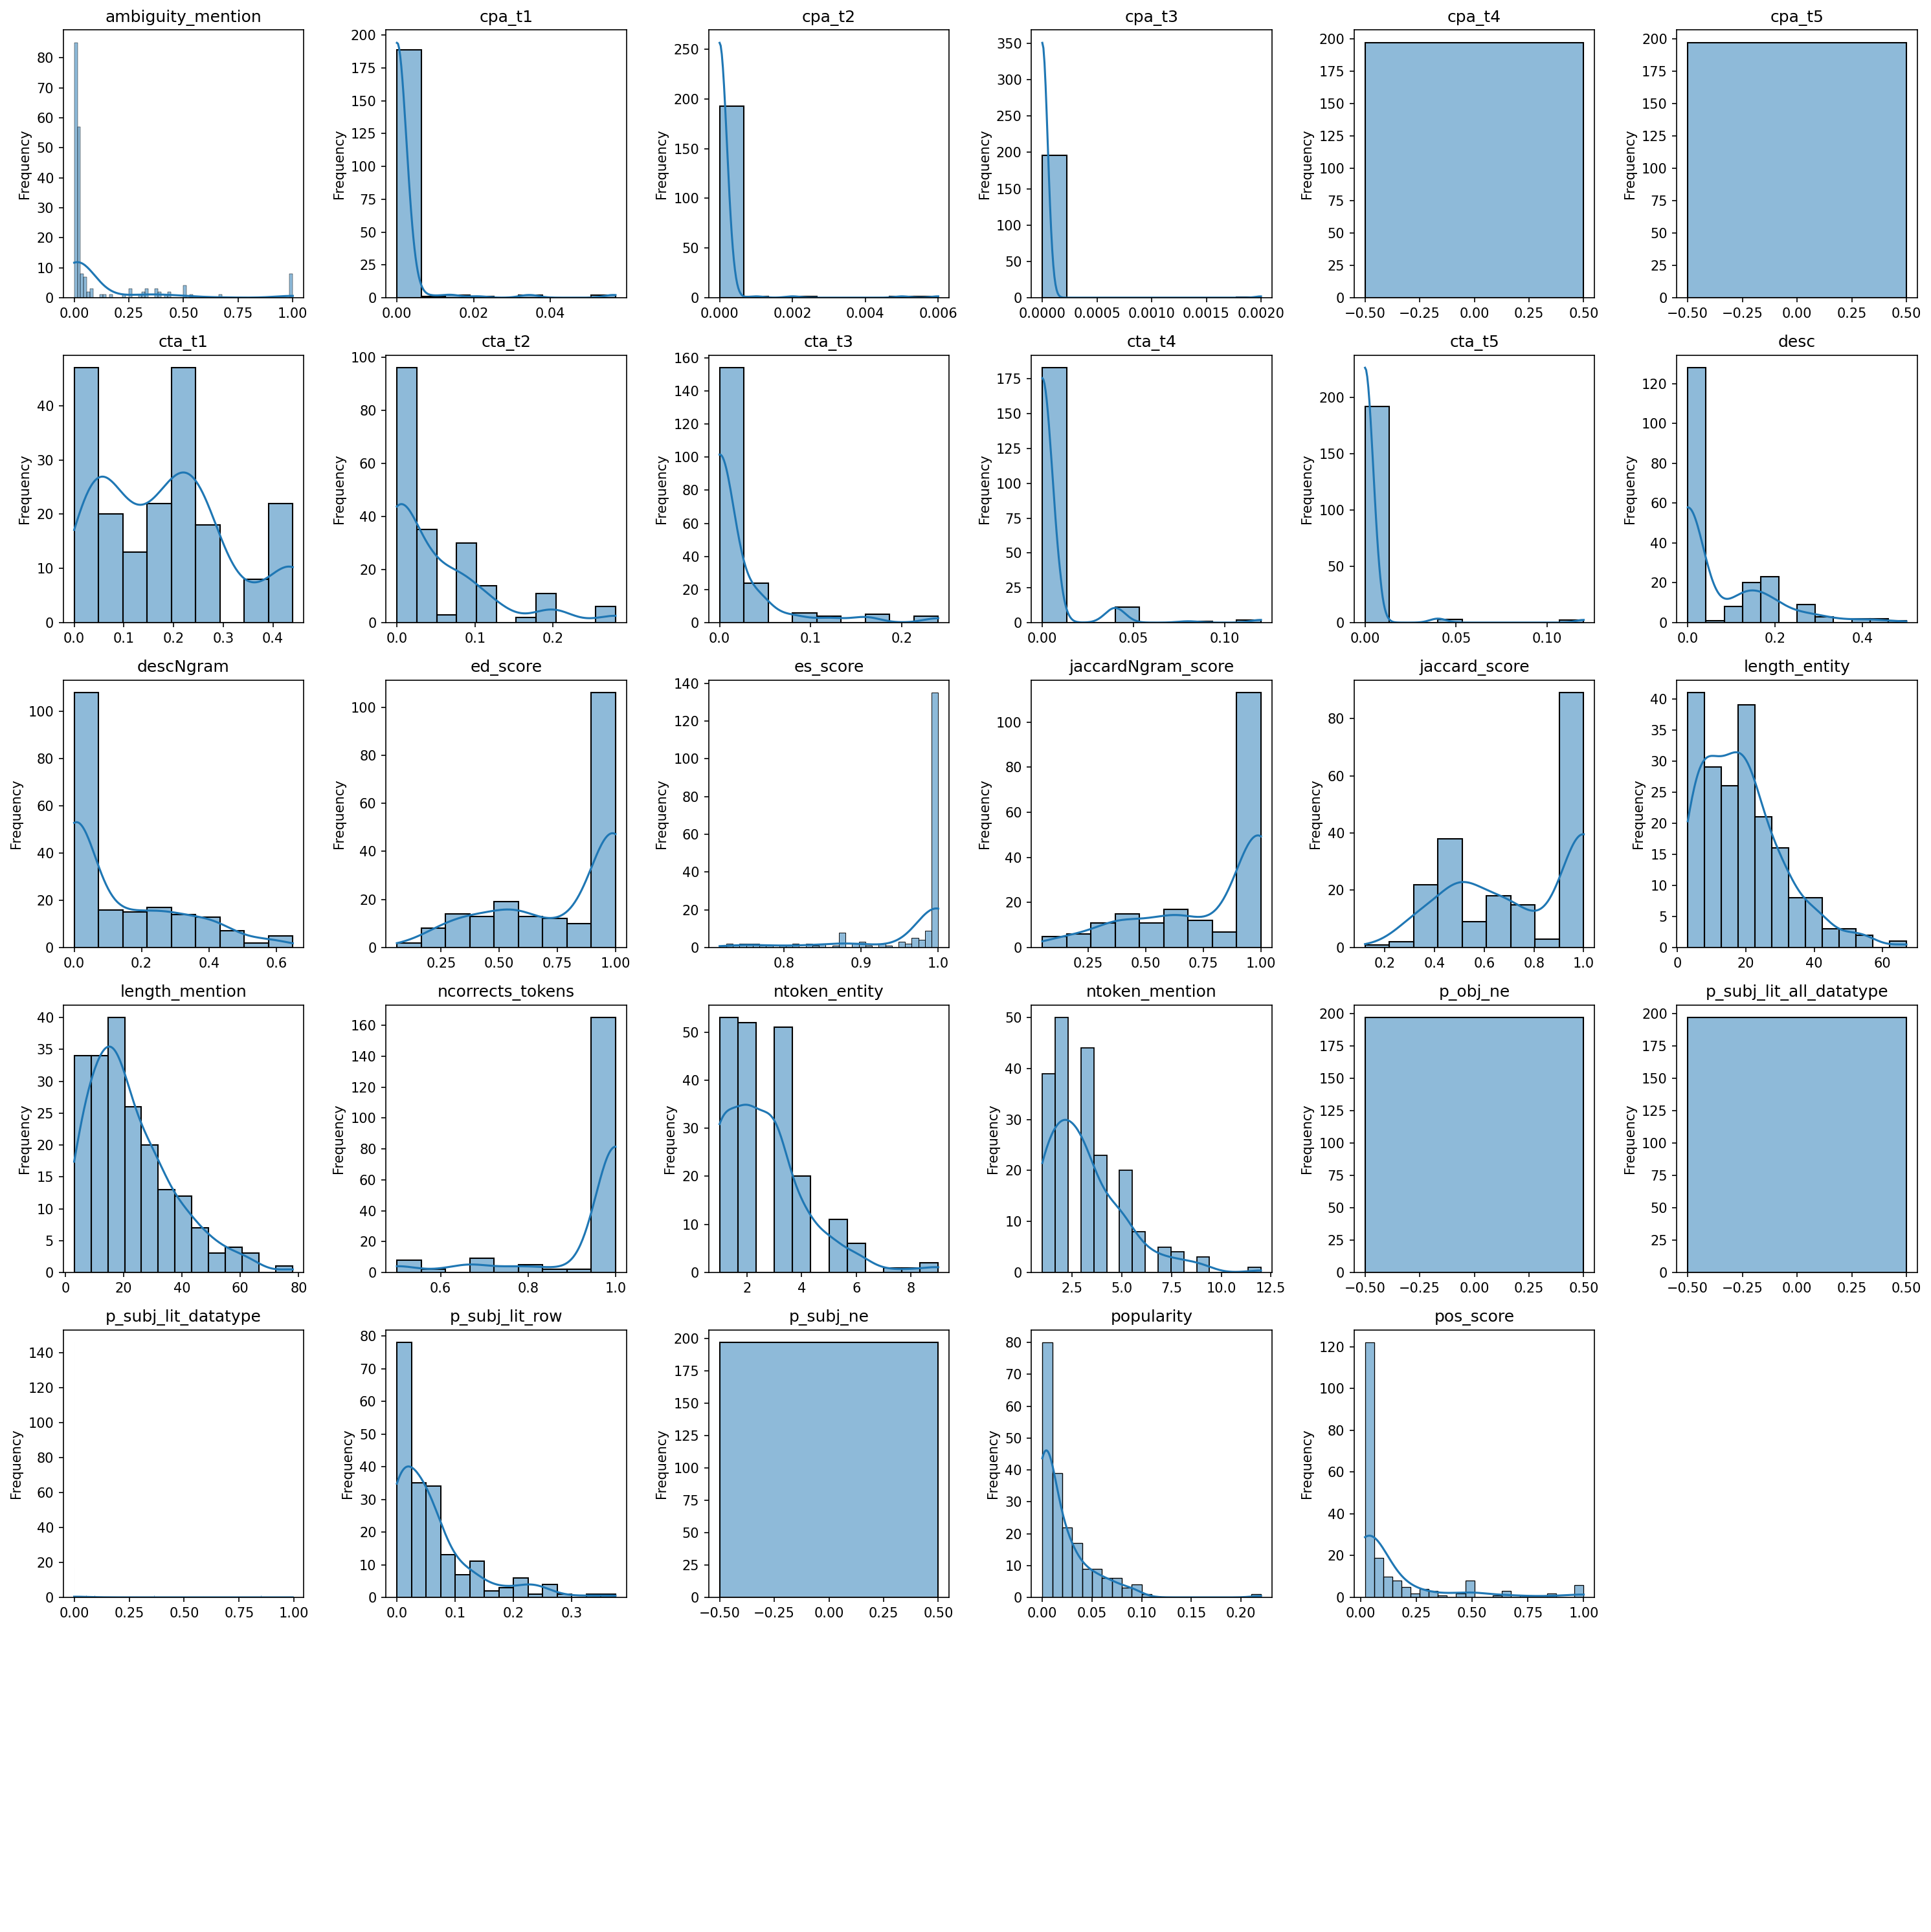

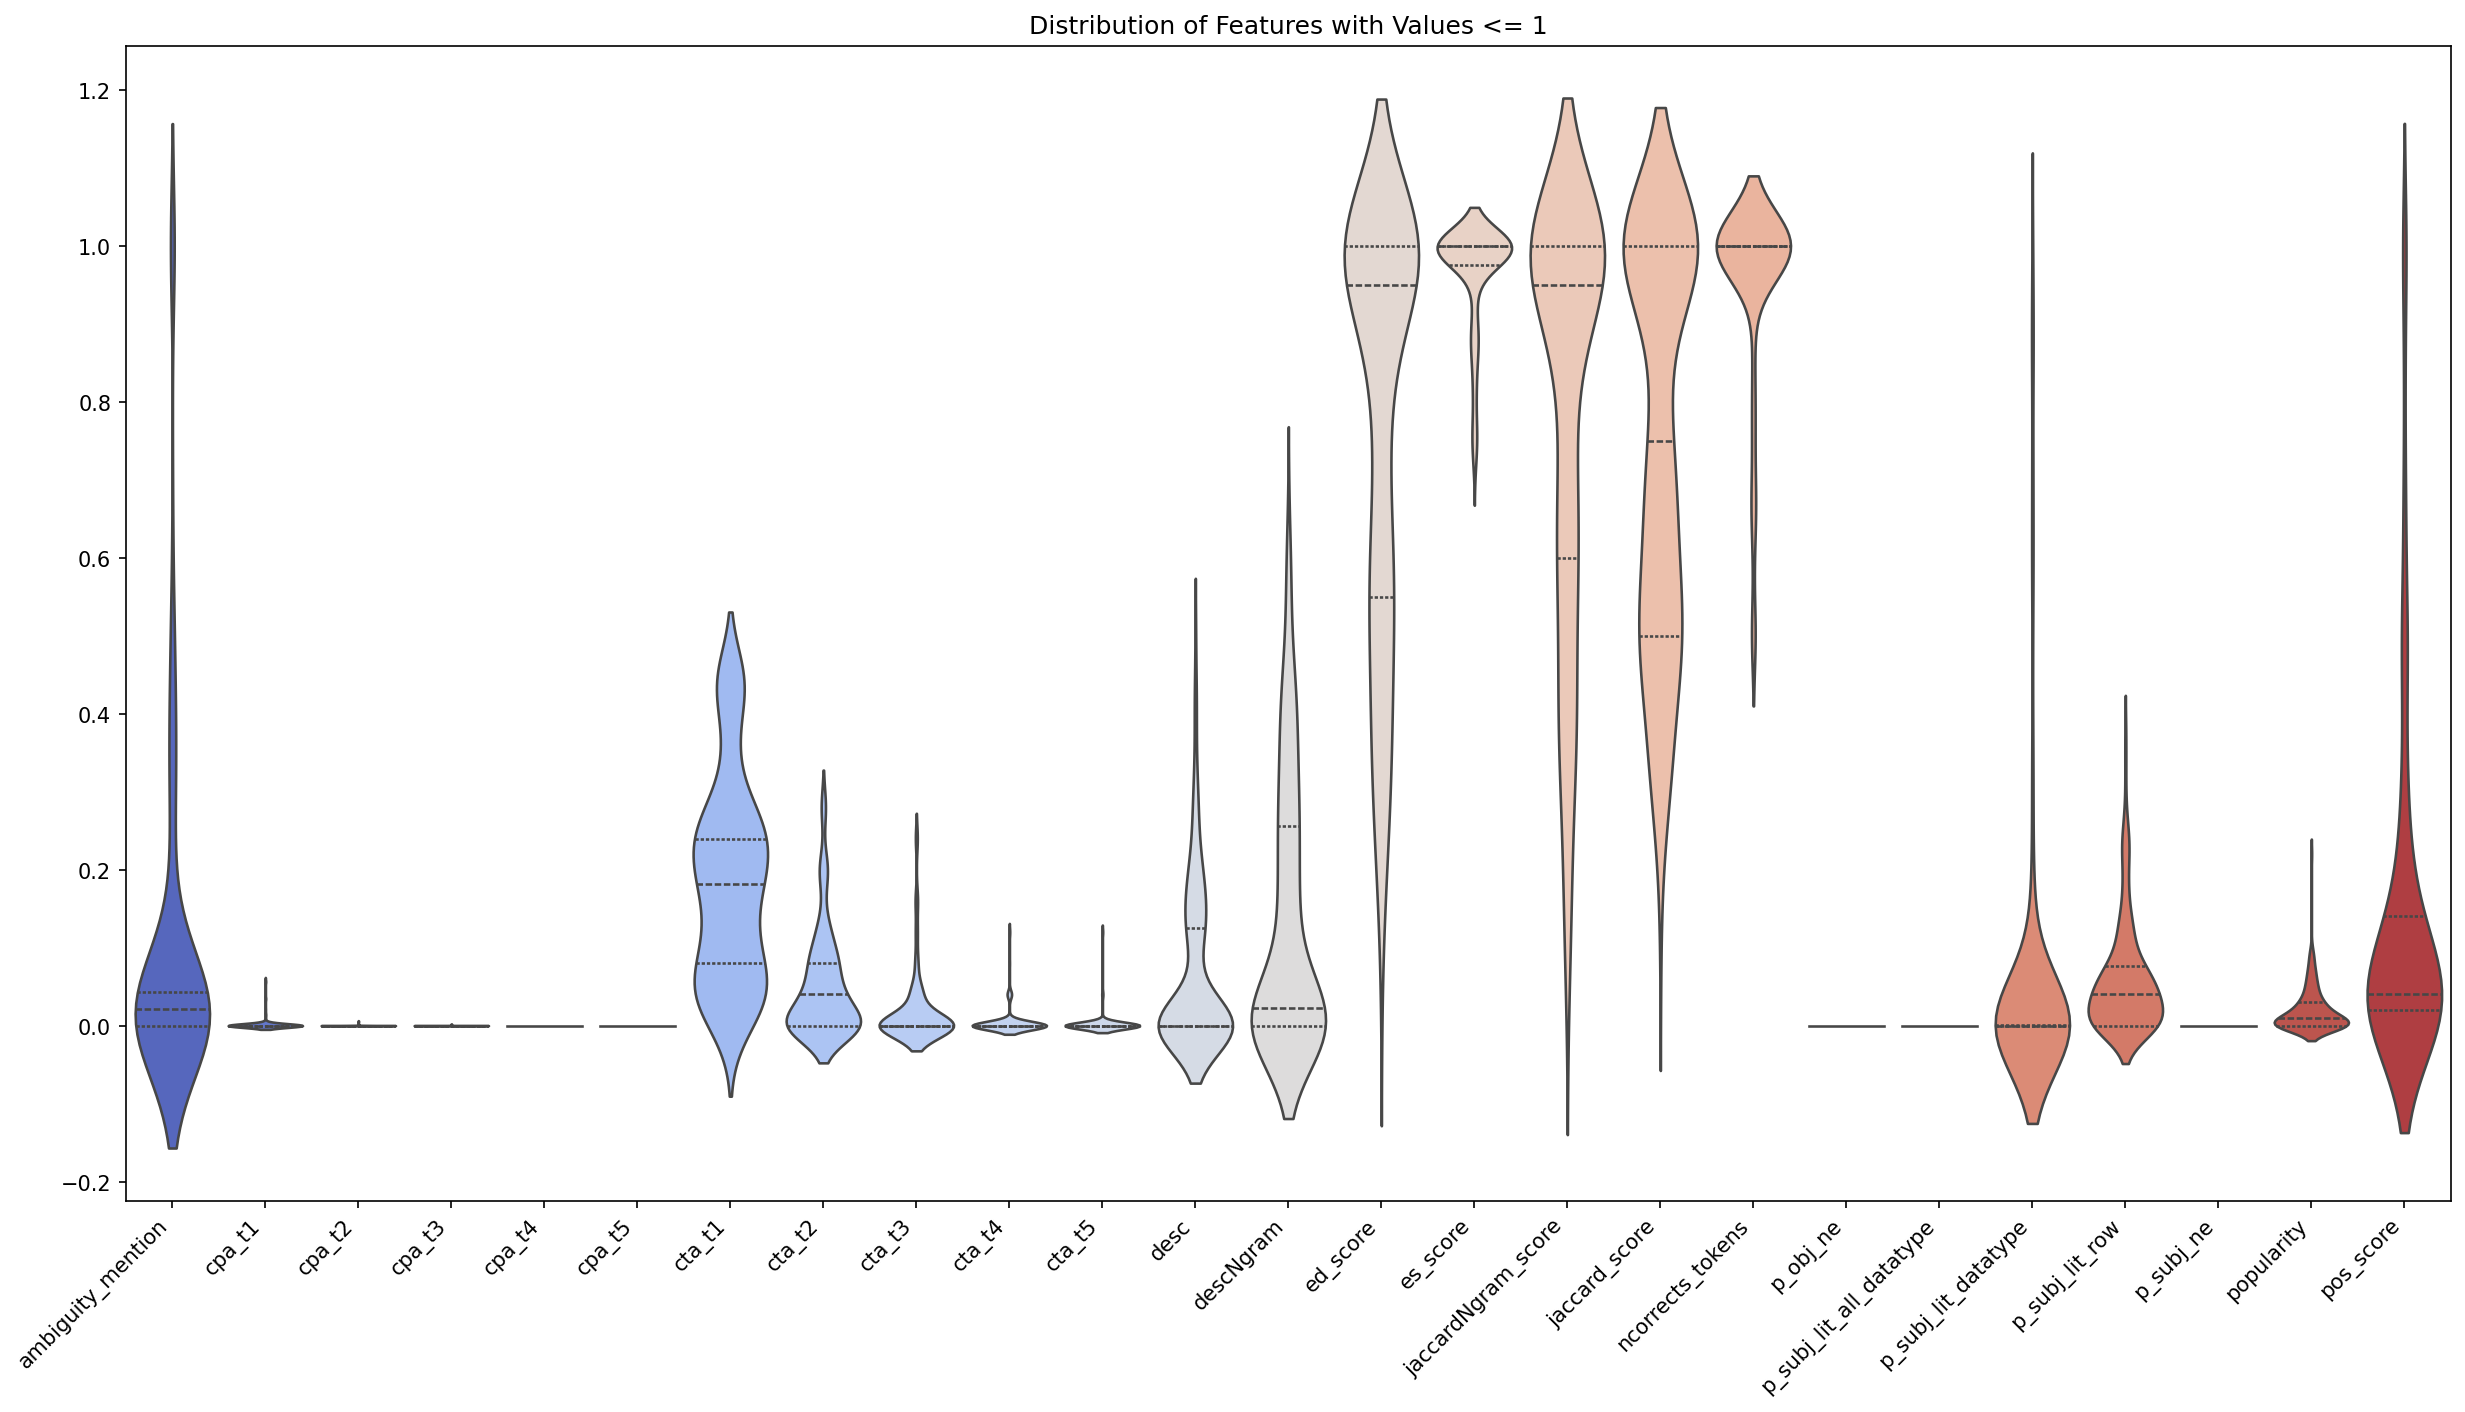

<ipython-input-2-e6ec125e3c60>:223: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=features_gt_one[column], inner='quartile', palette='coolwarm')


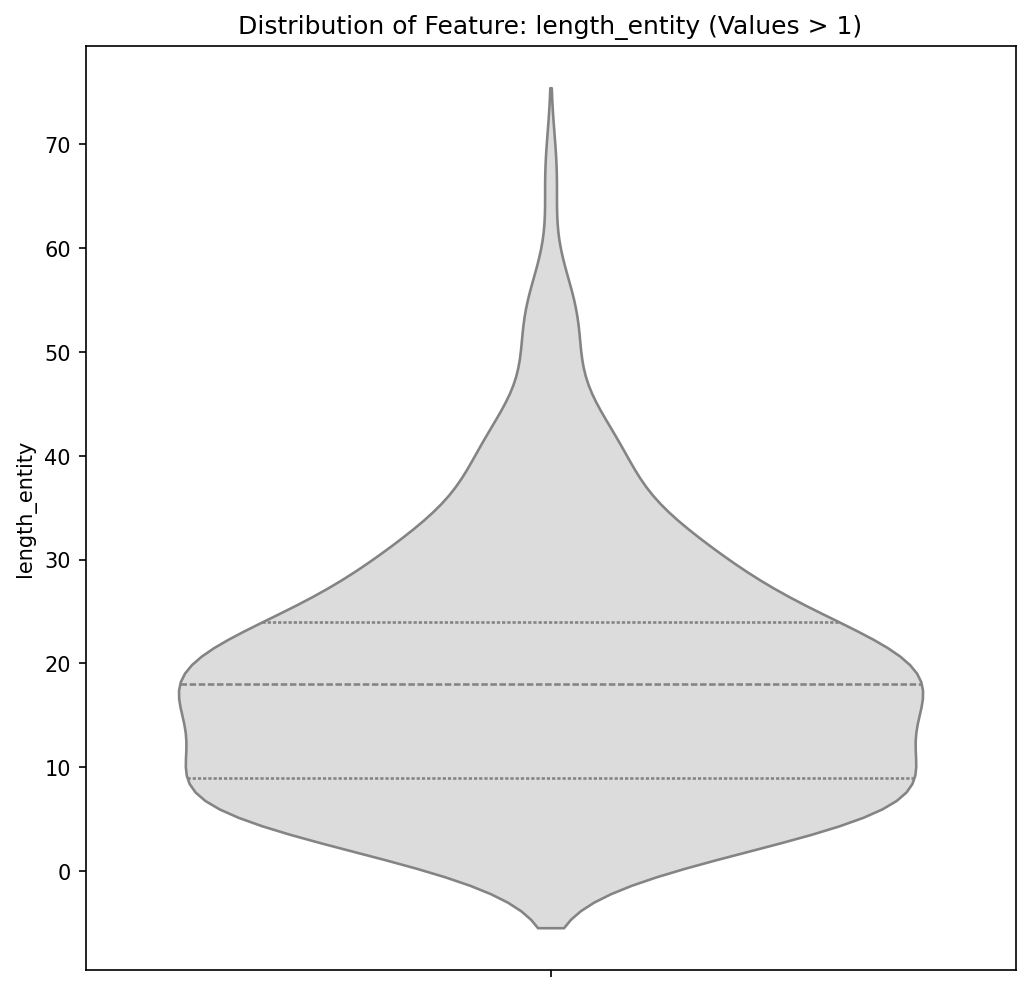

<ipython-input-2-e6ec125e3c60>:223: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=features_gt_one[column], inner='quartile', palette='coolwarm')


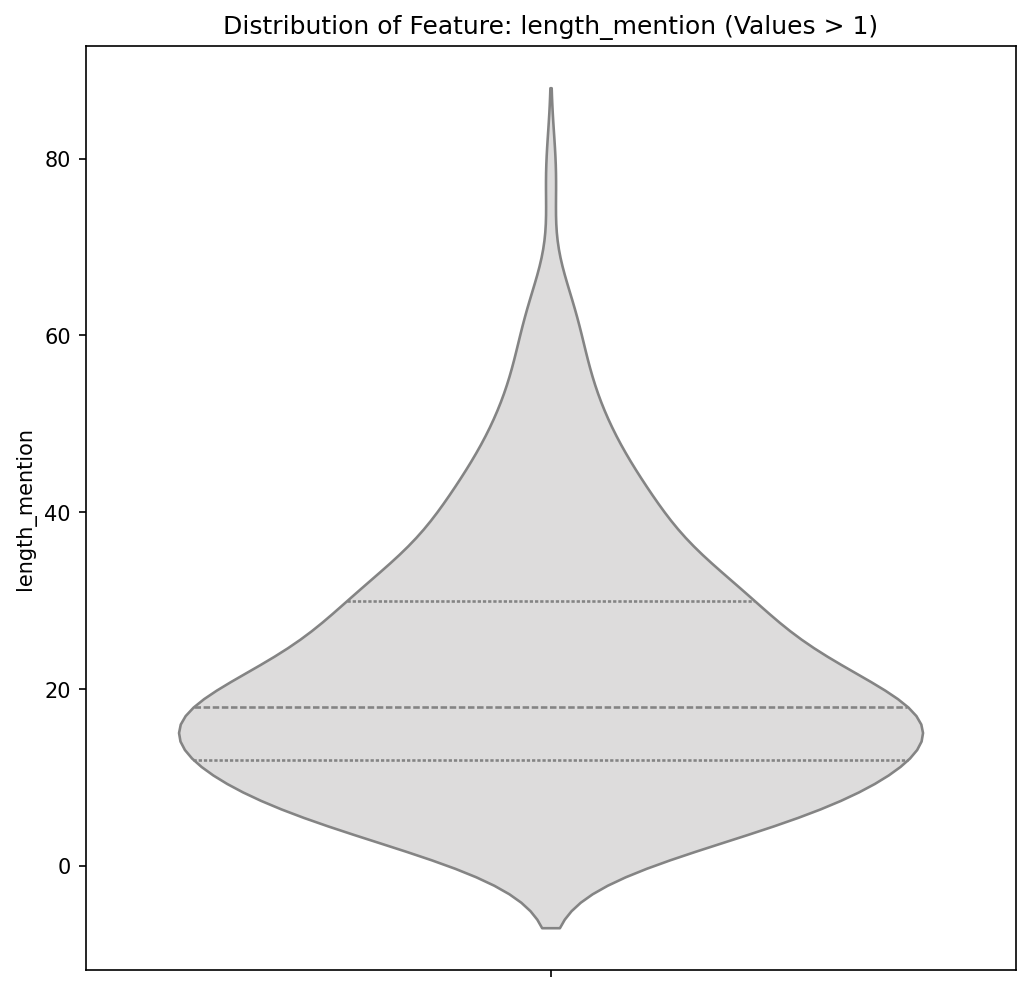

<ipython-input-2-e6ec125e3c60>:223: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=features_gt_one[column], inner='quartile', palette='coolwarm')


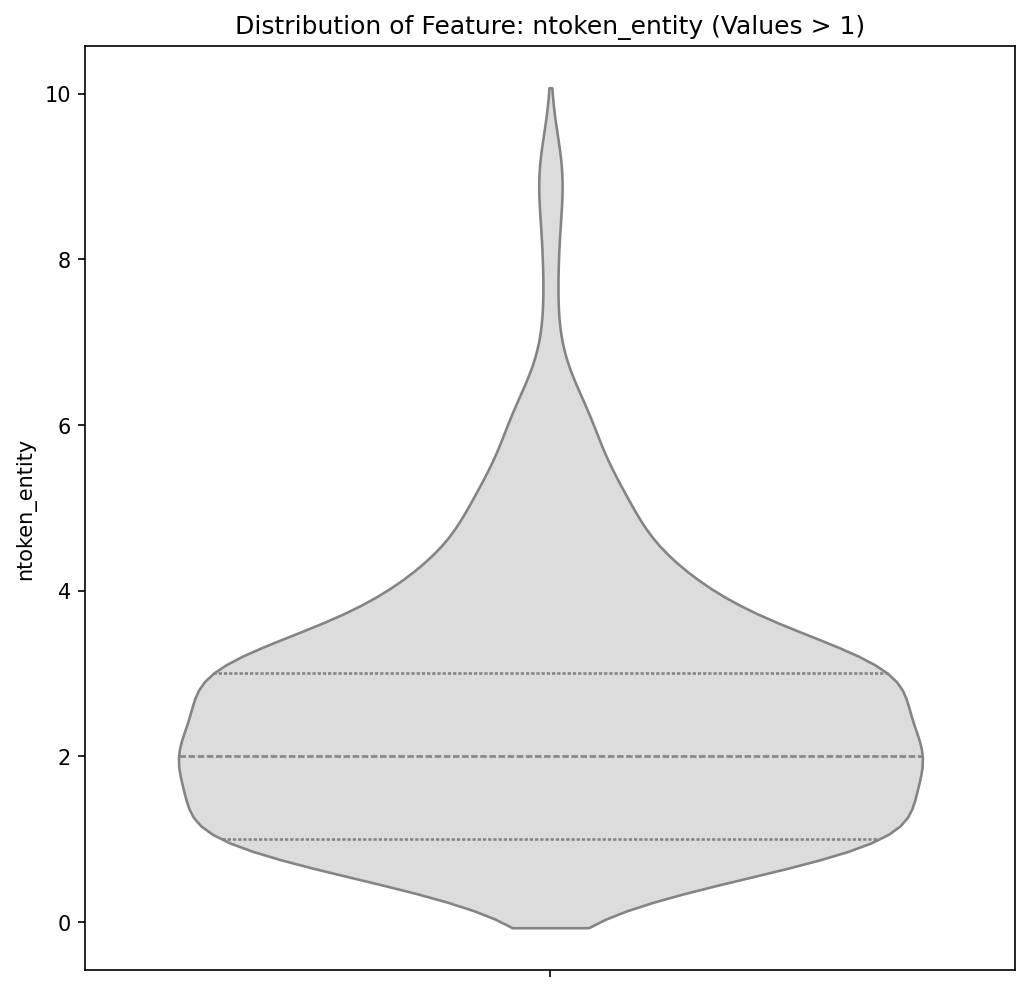

<ipython-input-2-e6ec125e3c60>:223: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=features_gt_one[column], inner='quartile', palette='coolwarm')


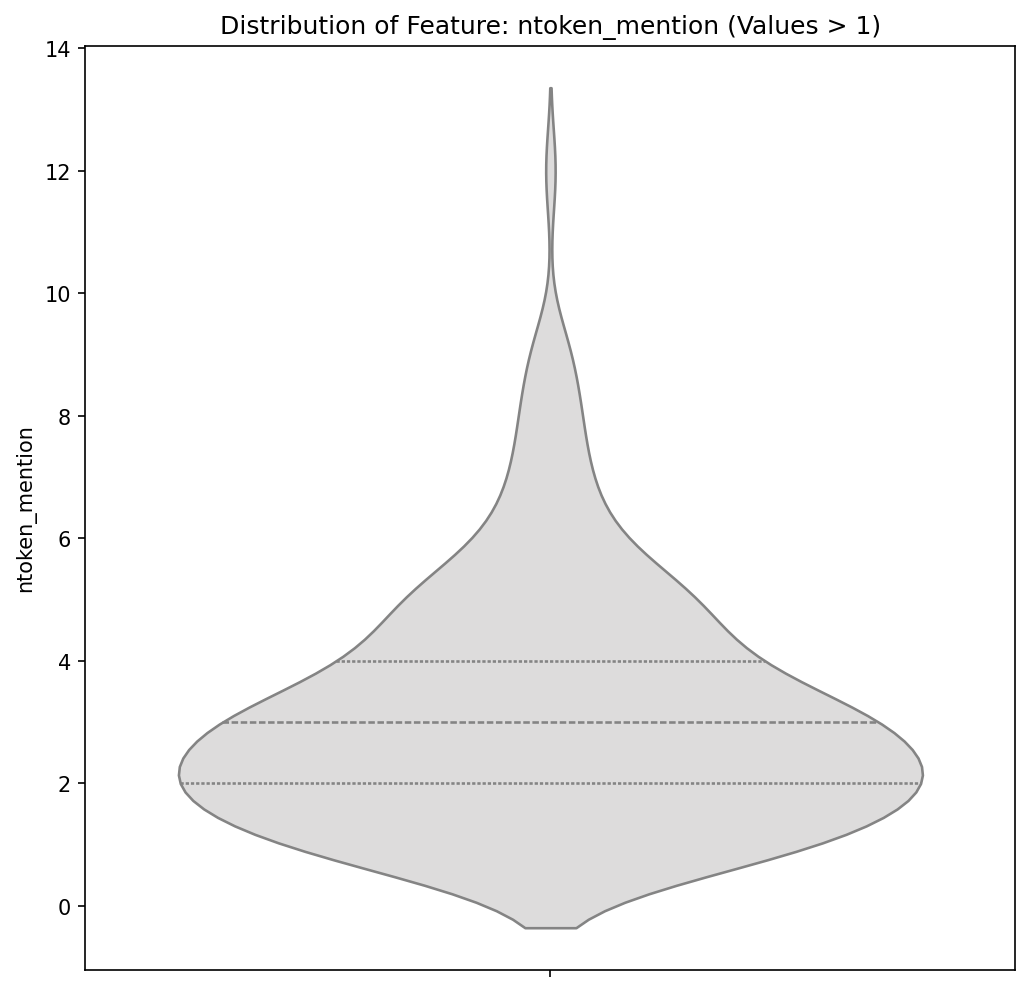

In [ ]:
plot_feature_distributions(correct_candidate_features_gh_testset)